In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import glob
import itertools
from datetime import timedelta
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.tri import Triangulation
import matplotlib.ticker as mticker

from sklearn.utils import resample
from scipy.signal import welch

import os
import pathlib
import sys

sys.path.append(str(pathlib.Path(os.getcwd()).parent))

%load_ext autoreload
%autoreload 2

from tools import eval_tools, cal_print_metrics

rmse = eval_tools.get_module_class('metrics', 'rmse')()

main_dir = '/Users/josephlee/Documents/others/WE-Validate/'
# main_dir = '/Users/leec813/GitHub/WE-Validate-DAP/'

def read_ts_df(case, org, sub=None):

    if sub is None:
        sub_dir = 'output/'
    else:
        sub_dir = 'output/'+sub+'/'

    df = pd.read_csv(main_dir+sub_dir+case+'/ts_'+org+'.csv', header=[0, 1, 2], index_col=[0])
    df.index = pd.to_datetime(df.index)
    
    return df

def get_summary_df(case, org, var, sub=None):

    df = read_ts_df(case, org, sub=sub)
    
    if var == 'power':
        df.drop(columns=case.split('-')[0]+'_'+var, level=2, inplace=True)
    else:
        df.drop(columns=case+'_'+var, level=2, inplace=True)

    df.columns = df.columns.droplevel(2)

    iterables = [df.columns.levels[0], ['mean', 'median', 'std', 'min', 'max']]

    df_sum = pd.DataFrame(columns=pd.MultiIndex.from_product(iterables))

    for hgt in df.columns.levels[0]: 

        df_sum[hgt, 'mean'] = df[hgt].mean(axis=1)
        df_sum[hgt, 'median'] = df[hgt].median(axis=1)
        df_sum[hgt, 'std'] = df[hgt].std(axis=1)
        df_sum[hgt, 'min'] = df[hgt].min(axis=1)
        df_sum[hgt, 'max'] = df[hgt].max(axis=1)
        
    return df_sum

def read_metrics_df(case, org, sub=None):

    if sub is None:
        sub_dir = 'output/'
    else:
        sub_dir = 'output/'+sub+'/'

    return pd.read_csv(main_dir+sub_dir+case+'/metrics_'+org+'.csv', header=[0, 1, 2], index_col=[0])

def get_metrics_df(case, org_list, sub=None):

    for ind, org in enumerate(org_list):

        df = read_metrics_df(case, org, sub=sub)

        if ind == 0: 
            df_metrics = df
        else:
            df_metrics = df_metrics.join(df)
            
    return df_metrics

p1_clr, p2_clr, p3_clr = 'magenta', 'mediumorchid', 'navy'
p4_clr, p5_clr, p6_clr = 'royalblue', 'deepskyblue', 'cyan'
p4_sclr, p5_sclr = 'cornflowerblue', 'skyblue'

select_p_color = [p4_sclr, p5_sclr, 'k']
select_x_color = [p4_clr, p5_clr, 'k']

def plot_p4p5all_stat(case, p4p5_df, all_df, lev):

    lev_str = str(lev)

    p4_col = [col for col in p4p5_df.columns.get_level_values(1) if 'p4' in col]
    p5_col = [col for col in p4p5_df.columns.get_level_values(1) if 'p5' in col]

    p4_metrics = p4p5_df.loc(axis=1)[lev_str, p4_col, :]
    p4_metrics.columns = pd.MultiIndex.from_product([[lev], ['p4'], 
                                                     list(p4_metrics.columns.get_level_values(1).unique())])

    p5_metrics = p4p5_df.loc(axis=1)[lev_str, p5_col, :]
    p5_metrics.columns = pd.MultiIndex.from_product([[lev], ['p5'], 
                                                     list(p5_metrics.columns.get_level_values(1).unique())])

    allm_metrics = all_df.loc(axis=1)[lev_str, :, :].drop((lev_str, 'allm', 'allm_ws'), axis=1)
    allm_metrics.columns = pd.MultiIndex.from_product([[lev], ['all'], 
                                                       list(allm_metrics.columns.get_level_values(1).unique())])

    p45_metric_df = pd.concat([p4_metrics, p5_metrics, allm_metrics], axis=1)

    p45_metric_df.columns.set_names(['t1', 't2', 't3'], inplace=True)

    mean_metrics = all_df.loc(axis=1)[lev_str, ['p4m', 'p5m', 'allm'], :]

    # need to hard code because there is a bug in pandas
    # after dropping columns or selecting columns, all the column names still exist
    # specifically, mean_metrics.columns.levels[1] != mean_metrics.columns
    # perhaps needs .remove_unused_levels()
    d1 = dict(zip(['allm_ws', 'p4m_ws', 'p5m_ws'], ['all', 'p4', 'p5']))
    mean_metrics = mean_metrics.rename(columns=d1, level=-1)

    mean_metrics.columns.set_names(['t1', 't2', 't3'], inplace=True)

#     select_p_color = ['royalblue', 'deepskyblue', 'k']

    # for metric in mean_metrics.index: 

    #     fig, ax = plt.subplots()

    #     sns.swarmplot(x='t2', y='value', data=p45_metric_df.melt(ignore_index=False).loc[metric], ax=ax, alpha=0.6, 
    #                   palette=select_p_color, edgecolor='black')
    #     sns.swarmplot(x='t3', y='value', data=mean_metrics.melt(ignore_index=False).loc[metric], edgecolor='k', 
    #                   linewidth=1.2, marker='X', size=15, ax=ax, palette=select_p_color, alpha=0.3)

    #     #     ax.scatter('p4', 110, c='k')
    #     #     ax.scatter('all', 112, c='k')

    #     plt.title(case+' ws '+metric+' @ '+lev_str+' m')
    #     plt.xlabel('org')
    #     #     plt.legend()

    #     plt.show()
        
    return p45_metric_df, mean_metrics

def get_hit_pct(df):

    df_c = df.copy(deep=True)

    for index, row in df.iterrows():

        org_cols = list(df.columns.drop([case, 'hit']))

        row_min = np.min(row.loc[org_cols])
        row_max = np.max(row.loc[org_cols])

        if (row[case] >= row_min) and (row[case] <= row_max):
            df_c.loc[index, 'hit'] = 1

    return 100*df_c['hit'].sum()/len(df_c)

def get_rmse(df):
    
    rmse_list = []
    
    for org in list(df.columns.drop([case, 'hit'])): 

        rmse_list.append(rmse.compute(df[case], df[org]))

    return np.mean(rmse_list)

## data

### wfip2

In [2]:
case = 'wfip2'

df_p1 = read_ts_df(case, 'p1', sub='60min')
df_p2 = read_ts_df(case, 'p2', sub='60min')
df_p4 = read_ts_df(case, 'p4', sub='60min')
df_p5 = read_ts_df(case, 'p5', sub='60min')
df_p6 = read_ts_df(case, 'p6', sub='60min')

var = 'ws'

df_p2_sum = get_summary_df(case, 'p2', var, sub='60min')
df_p4_sum = get_summary_df(case, 'p4', var, sub='60min')
df_p5_sum = get_summary_df(case, 'p5', var, sub='60min')

means_output_dir = main_dir+'data/submissions/means/'

# p1 and p6 only have 1 model submission
df_p1.xs('p1_ws', axis=1, level=2).droplevel(axis=1, level=1).add_prefix('wind-speed_').add_suffix('m').to_csv(
    os.path.join(means_output_dir, 'p1_'+case+'.csv'))
df_p6.xs('p6-1_ws', axis=1, level=2).droplevel(axis=1, level=1).add_prefix('wind-speed_').add_suffix('m').to_csv(
    os.path.join(means_output_dir, 'p6_'+case+'.csv'))

p_list = ['p2', 'p4', 'p5']
df_p_list = [df_p2_sum, df_p4_sum, df_p5_sum]

for p in zip(p_list, df_p_list):

    p[1].xs('mean', axis=1, level=1).add_prefix('wind-speed_').add_suffix('m').to_csv(
        os.path.join(means_output_dir, p[0]+'_mean_'+case+'.csv'))
    
org_mean_alllev_df = pd.DataFrame(columns=df_p1.columns.levels[0])

for lev in org_mean_alllev_df.columns:

    org_mean_df = pd.DataFrame()

    org_mean_df['p1'] = df_p1[lev]['p1']['p1_ws']
    org_mean_df['p2'] = df_p2_sum[lev]['mean']
    org_mean_df['p4'] = df_p4_sum[lev]['mean']
    org_mean_df['p5'] = df_p5_sum[lev]['mean']
    org_mean_df['p6'] = df_p6[lev]['p6-1']['p6-1_ws']

    org_mean_df.dropna(inplace=True)
    
    org_mean_alllev_df[lev] = org_mean_df.mean(axis=1)
    
org_mean_alllev_df.add_prefix('wind-speed_').add_suffix('m').to_csv(
    os.path.join(means_output_dir, 'orgs_mean_'+case+'.csv'))

org_mean_alllev_df_wfip2 = org_mean_alllev_df.copy()

lev = '80'

org_mean_df = pd.DataFrame()

org_mean_df['p1'] = df_p1[lev]['p1']['p1_ws']
org_mean_df['p2'] = df_p2_sum[lev]['mean']
org_mean_df['p4'] = df_p4_sum[lev]['mean']
org_mean_df['p5'] = df_p5_sum[lev]['mean']
org_mean_df['p6'] = df_p6[lev]['p6-1']['p6-1_ws']
org_mean_df[case] = df_p1[lev]['p1'][case+'_ws']

org_mean_df.dropna(inplace=True)

org_mean_df_wfip2 = org_mean_df.copy()

df_p1_wfip2 = df_p1.copy()
df_p2_sum_wfip2 = df_p2_sum.copy()
df_p4_sum_wfip2 = df_p4_sum.copy()
df_p5_sum_wfip2 = df_p5_sum.copy()
df_p6_wfip2 = df_p6.copy()

df_metrics_wfip2 = get_metrics_df(case, ['p4', 'p5'], sub='60min')
df_metrics_wfip2_allm = get_metrics_df(case+'/allmeans', ['allmeans'], sub='60min')

p45_metric_df_wfip2, mean_metrics_wfip2 = plot_p4p5all_stat(case, df_metrics_wfip2, df_metrics_wfip2_allm, 80)

### fino2

In [3]:
lev = 82

case = 'fino'
var = 'ws'

df_p5_sum = get_summary_df(case, 'p5', var, sub='60min')
df_p4_sum = get_summary_df(case, 'p4', var, sub='60min')
df_p3_sum = get_summary_df(case, 'p3', var, sub='60min')
df_p2_sum = get_summary_df(case, 'p2', var, sub='60min')

df_p1 = read_ts_df(case, 'p1', sub='60min')
df_p6 = read_ts_df(case, 'p6', sub='60min')
    
lev = str(lev)

means_output_dir = main_dir+'data/submissions/means/'

df_p1.xs('p1_ws', axis=1, level=2).droplevel(axis=1, level=1).add_prefix('wind-speed_').add_suffix('m').to_csv(
    os.path.join(means_output_dir, 'p1_'+case+'.csv'))
df_p6.xs('p6-1_ws', axis=1, level=2).droplevel(axis=1, level=1).add_prefix('wind-speed_').add_suffix('m').to_csv(
    os.path.join(means_output_dir, 'p6_'+case+'.csv'))

p_list = ['p2', 'p3', 'p4', 'p5']
df_p_list = [df_p2_sum, df_p3_sum, df_p4_sum, df_p5_sum]

for p in zip(p_list, df_p_list):

    p[1].xs('mean', axis=1, level=1).add_prefix('wind-speed_').add_suffix('m').to_csv(
        os.path.join(means_output_dir, p[0]+'_mean_'+case+'.csv'))
    
org_mean_alllev_df = pd.DataFrame(columns=df_p1.columns.levels[0])

for lev in org_mean_alllev_df.columns:

    org_mean_df = pd.DataFrame()

    org_mean_df['p1'] = df_p1[lev]['p1']['p1_ws']
    org_mean_df['p2'] = df_p2_sum[lev]['mean']
    org_mean_df['p3'] = df_p3_sum[lev]['mean']
    org_mean_df['p4'] = df_p4_sum[lev]['mean']
    org_mean_df['p5'] = df_p5_sum[lev]['mean']
    org_mean_df['p6'] = df_p6[lev]['p6-1']['p6-1_ws']

    org_mean_df.dropna(inplace=True)
    
    org_mean_alllev_df[lev] = org_mean_df.mean(axis=1)
    
org_mean_alllev_df.add_prefix('wind-speed_').add_suffix('m').to_csv(
    os.path.join(means_output_dir, 'orgs_mean_'+case+'.csv'))

org_mean_df = pd.DataFrame()

org_mean_df['p3'] = df_p3_sum[lev]['mean']
org_mean_df['p2'] = df_p2_sum[lev]['mean']
org_mean_df['p4'] = df_p4_sum[lev]['mean']
org_mean_df['p1'] = df_p1[lev]['p1']['p1_ws']
org_mean_df['p5'] = df_p5_sum[lev]['mean']
org_mean_df[case] = df_p1[lev]['p1'][case+'_ws']

org_mean_df['hit'] = 0

org_mean_df.dropna(inplace=True)

org_median_df = pd.DataFrame()

org_median_df['p3'] = df_p3_sum[lev]['median']
org_median_df['p2'] = df_p2_sum[lev]['median']
org_median_df['p4'] = df_p4_sum[lev]['median']
org_median_df['p1'] = df_p1[lev]['p1']['p1_ws']
org_median_df['p5'] = df_p5_sum[lev]['median']
org_median_df[case] = df_p1[lev]['p1'][case+'_ws']

org_median_df.dropna(inplace=True)

org_base_df = org_mean_df.drop(columns='hit')

df_p1_fino2 = df_p1.copy()
df_p2_sum_fino2 = df_p2_sum.copy()
df_p3_sum_fino2 = df_p3_sum.copy()
df_p4_sum_fino2 = df_p4_sum.copy()
df_p5_sum_fino2 = df_p5_sum.copy()

org_base_df_fino2 = org_base_df.copy()

df_metrics_fino = get_metrics_df(case, ['p4', 'p5'], sub='60min')
df_metrics_fino_allm = get_metrics_df(case+'/allmeans', ['allmeans'], sub='60min')

p45_metric_df_fino, mean_metrics_fino = plot_p4p5all_stat(case, df_metrics_fino, df_metrics_fino_allm, 82)

### baltic power

In [4]:
means_output_dir = main_dir+'data/submissions/means/'
case = 'baltic-power'

df_p1 = read_ts_df(case, 'p1', sub='60min')
df_p1.xs('p1_power', axis=1, level=2).droplevel(axis=1, level=1).add_prefix('power_').add_suffix('m').to_csv(
    os.path.join(means_output_dir, 'p1_'+case+'.csv'))

df_p2_sum = get_summary_df(case, 'p2', 'power', sub='60min')
df_p3_sum = get_summary_df(case, 'p3', 'power', sub='60min')
df_p4_sum = get_summary_df(case, 'p4', 'power', sub='60min')
df_p5_sum = get_summary_df(case, 'p5', 'power', sub='60min')

df_p6 = read_ts_df(case, 'p6', sub='60min')
df_p6.xs('p6-1_power', axis=1, level=2).droplevel(axis=1, level=1).add_prefix('power_').add_suffix('m').to_csv(
    os.path.join(means_output_dir, 'p6_'+case+'.csv'))

means_output_dir = main_dir+'data/submissions/means/'

p_list = ['p2', 'p3', 'p4', 'p5']
df_p_list = [df_p2_sum, df_p3_sum, df_p4_sum, df_p5_sum]

for p in zip(p_list, df_p_list):

    p[1].xs('mean', axis=1, level=1).add_prefix('power_').add_suffix('m').to_csv(
        os.path.join(means_output_dir, p[0]+'_mean_'+case+'.csv'))
    
org_mean_alllev_df = pd.DataFrame(columns=df_p1.columns.levels[0])

for lev in org_mean_alllev_df.columns:

    org_mean_df = pd.DataFrame()

    org_mean_df['p1'] = df_p1[lev]['p1']['p1_power']
    org_mean_df['p2'] = df_p2_sum[lev]['mean']
    org_mean_df['p3'] = df_p3_sum[lev]['mean']
    org_mean_df['p4'] = df_p4_sum[lev]['mean']
    org_mean_df['p5'] = df_p5_sum[lev]['mean']
    org_mean_df['p6'] = df_p6[lev]['p6-1']['p6-1_power']

    org_mean_df.dropna(inplace=True)
    
    org_mean_alllev_df[lev] = org_mean_df.mean(axis=1)
    
org_mean_alllev_df.add_prefix('power_').add_suffix('m').to_csv(
    os.path.join(means_output_dir, 'orgs_mean_'+case+'.csv'))

# the below is for rank pie chart
org_mean_df[case] = df_p1[lev]['p1']['baltic_power']

org_mean_df.dropna(inplace=True)

org_ae_df = pd.DataFrame()

for col in org_mean_df.drop(columns=case):
    
    org_ae_df[col] = abs(org_mean_df[col] - org_mean_df[case])

org_ae_df['avg'] = abs(org_mean_df.drop(columns=case).mean(axis=1) - org_mean_df[case])

org_rankae_df = pd.DataFrame(columns=org_ae_df.columns)

for index, row in org_ae_df.iterrows():
    
    org_rankae_df.loc[index] = row.rank()
    
df_p4 = read_ts_df('baltic-power/p4_ensemble', 'p4')
df_p5 = read_ts_df('baltic-power/p5_ensemble', 'p5')

df_p1_baltic = df_p1.copy()
df_p2_sum_baltic = df_p2_sum.copy()
df_p3_sum_baltic = df_p3_sum.copy()
df_p4_sum_baltic = df_p4_sum.copy()
df_p5_sum_baltic = df_p5_sum.copy()
df_p6_baltic = df_p6.copy()

org_mean_alllev_df_baltic = org_mean_alllev_df.copy()

In [6]:
df_metrics_bp = get_metrics_df('baltic-power', ['p4', 'p5'], sub='60min')

df_metrics_bp_allm = get_metrics_df('baltic-power/allmeans', ['allmeans'], sub='60min')

p4_col = [col for col in df_metrics_bp.columns.get_level_values(1) if 'p4' in col]
p5_col = [col for col in df_metrics_bp.columns.get_level_values(1) if 'p5' in col]

p4_metrics = df_metrics_bp.loc(axis=1)['78.25', p4_col, :]
p4_metrics.columns = pd.MultiIndex.from_product([[78.25], ['p4'], 
                                                 list(p4_metrics.columns.get_level_values(1).unique())])

p5_metrics = df_metrics_bp.loc(axis=1)['78.25', p5_col, :]
p5_metrics.columns = pd.MultiIndex.from_product([[78.25], ['p5'], 
                                                 list(p5_metrics.columns.get_level_values(1).unique())])

allm_metrics = df_metrics_bp_allm.drop(('78.25', 'allm', 'allm_power'), axis=1)
allm_metrics.columns = pd.MultiIndex.from_product([[78.25], ['all'], 
                                                   list(allm_metrics.columns.get_level_values(1).unique())])

p45_metric_df = pd.concat([p4_metrics, p5_metrics, allm_metrics], axis=1)

p45_metric_df.columns.set_names(['t1', 't2', 't3'], inplace=True)

mean_metrics = df_metrics_bp_allm.loc(axis=1)[:, ['p4m', 'p5m', 'allm'], :]

# need to hard code because there is a bug in pandas
# after dropping columns or selecting columns, all the column names still exist
# specifically, mean_metrics.columns.levels[1] != mean_metrics.columns
# perhaps needs .remove_unused_levels()
d1 = dict(zip(['allm_power', 'p4m_power', 'p5m_power'], ['all', 'p4', 'p5']))
mean_metrics = mean_metrics.rename(columns=d1, level=-1)

mean_metrics.columns.set_names(['t1', 't2', 't3'], inplace=True)

p45_metric_df_baltic = p45_metric_df.copy()
mean_metrics_baltic = mean_metrics.copy()

## old figs

### fig 3a

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


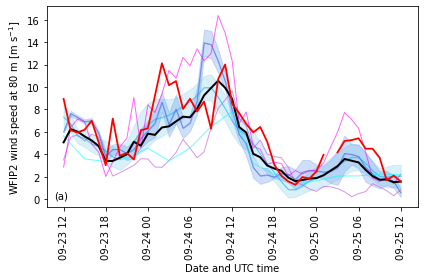

In [21]:
al_pha = 0.6

# colormap = plt.cm.gist_ncar

fig, ax = plt.subplots()

lev_wfip2 = '80'

mem_lw = 1

ax.plot(df_p5_sum.index, df_p5_sum[lev_wfip2]['mean'], c=p5_clr, label='p5', alpha=al_pha, linewidth=mem_lw)
ax.fill_between(df_p5_sum.index, df_p5_sum[lev_wfip2]['mean'], 
                df_p5_sum[lev_wfip2]['mean']+df_p5_sum[lev]['std'], color=p5_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

s5_down = df_p5_sum[lev_wfip2]['mean']-df_p5_sum[lev_wfip2]['std']
s5_down.loc[s5_down < 0] = 0
ax.fill_between(df_p5_sum.index, df_p5_sum[lev_wfip2]['mean'], s5_down, color=p5_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

ax.plot(df_p4_sum.index, df_p4_sum[lev_wfip2]['mean'], c=p4_clr, label='p4', alpha=al_pha, linewidth=mem_lw)
ax.fill_between(df_p4_sum.index, df_p4_sum[lev_wfip2]['mean'], 
                df_p4_sum[lev_wfip2]['mean']+df_p4_sum[lev_wfip2]['std'], color=p4_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

s4_down = df_p4_sum[lev_wfip2]['mean']-df_p4_sum[lev_wfip2]['std']
s4_down.loc[s4_down < 0] = 0
ax.fill_between(df_p4_sum.index, df_p4_sum[lev_wfip2]['mean'], s4_down, color=p4_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

ax.plot(df_p2_sum.index, df_p2_sum[lev_wfip2]['mean'], c=p2_clr, label='p2', alpha=al_pha, linewidth=mem_lw)

ax.plot(df_p1.index, df_p1[lev_wfip2]['p1']['p1_ws'], label='p1', c=p1_clr, alpha=al_pha, linewidth=mem_lw)

ax.plot(df_p6.index, df_p6[lev_wfip2]['p6-1']['p6-1_ws'], label='p6', c=p6_clr, alpha=al_pha, linewidth=mem_lw)

ax.plot(org_mean_df.index, org_mean_df.drop(columns=case).mean(axis=1), label='avg', c='k', linewidth=2)

ax.plot(df_p1.index, df_p1[lev_wfip2]['p1'][case+'_ws'], label='fino tower', c='red', linewidth=1.8)

var_txt = 'WFIP2 wind speed at '+lev_wfip2+' m'

plt.xticks(rotation=90)
plt.xlabel('Date and UTC time')
plt.ylabel(var_txt+r' [m s$^{-1}$]')
# plt.title(case+' case: '+var_txt)
# plt.legend(bbox_to_anchor=(1.03, 1.02), loc='upper left')

plt.text(0.02, 0.04, '(a)', transform=ax.transAxes)

plt.tight_layout()

plt.savefig('../publication/plot/Fig3a.pdf')
plt.savefig('../publication/plot/Fig3a.eps')

plt.show()

### fig 3b

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


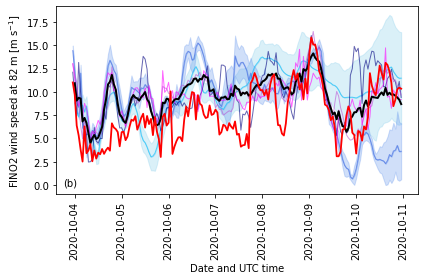

In [34]:
lev = '82'

al_pha = 0.6

colormap = plt.cm.gist_ncar

fig, ax = plt.subplots()

mem_lw = 1

ax.plot(df_p5_sum.index, df_p5_sum[lev]['mean'], c=p5_clr, label='p5', alpha=al_pha, linewidth=mem_lw)
ax.fill_between(df_p5_sum.index, df_p5_sum[lev]['mean'], 
                df_p5_sum[lev]['mean']+df_p5_sum[lev]['std'], color=p5_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

s5_down = df_p5_sum[lev]['mean']-df_p5_sum[lev]['std']
s5_down.loc[s5_down < 0] = 0
ax.fill_between(df_p5_sum.index, df_p5_sum[lev]['mean'], s5_down, color=p5_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

ax.plot(df_p4_sum.index, df_p4_sum[lev]['mean'], c=p4_clr, label='p4', alpha=al_pha, linewidth=mem_lw)
ax.fill_between(df_p4_sum.index, df_p4_sum[lev]['mean'], 
                df_p4_sum[lev]['mean']+df_p4_sum[lev]['std'], color=p4_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

s4_down = df_p4_sum[lev]['mean']-df_p4_sum[lev]['std']
s4_down.loc[s4_down < 0] = 0
ax.fill_between(df_p4_sum.index, df_p4_sum[lev]['mean'], s4_down, color=p4_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

ax.plot(df_p3_sum.index, df_p3_sum[lev]['mean'], c=p3_clr, label='p3', alpha=al_pha, linewidth=mem_lw)

ax.plot(df_p2_sum.index, df_p2_sum[lev]['mean'], c=p2_clr, label='p2', alpha=al_pha, linewidth=mem_lw)

ax.plot(df_p1.index, df_p1[lev]['p1']['p1_ws'], label='p1', c=p1_clr, alpha=al_pha, linewidth=mem_lw)

ax.plot(org_base_df.index, org_base_df.drop(columns=case).mean(axis=1), label='avg', c='k', linewidth=2)

ax.plot(df_p1.index, df_p1[lev]['p1'][case+'_ws'], label='fino tower', c='red', linewidth=1.8)

var_txt = 'FINO2 wind speed at '+lev+' m'

plt.xticks(rotation=90)
plt.xlabel('Date and UTC time')
plt.ylabel(var_txt+r' [m s$^{-1}$]')
# plt.title(case+' case: '+var_txt)
# plt.legend(bbox_to_anchor=(1.03, 1.02), loc='upper left')

plt.text(0.02, 0.04, '(b)', transform=ax.transAxes)

plt.tight_layout()

plt.savefig('../publication/plot/Fig3b.pdf')
plt.savefig('../publication/plot/Fig3b.eps')

plt.show()

### fig 3c

In [ ]:
al_pha = 0.6

colormap = plt.cm.gist_ncar

fig, ax = plt.subplots(figsize=(10, 8))

mem_lw = 1

ax.plot(df_p1.index, df_p1[lev]['p1']['p1_power'], label='p1', c=p1_clr, alpha=al_pha, linewidth=mem_lw)

ax.plot(df_p2_sum.index, df_p2_sum[lev]['mean'], c=p2_clr, label='p2', alpha=al_pha, linewidth=mem_lw)

ax.plot(df_p3_sum.index, df_p3_sum[lev]['mean'], c=p3_clr, label='p3', alpha=al_pha, linewidth=mem_lw)

ax.plot(df_p4_sum.index, df_p4_sum[lev]['mean'], c=p4_clr, label='p4', alpha=al_pha, linewidth=mem_lw)

s4_up = df_p4_sum[lev]['mean']+df_p4_sum[lev]['std']
s4_up.loc[s4_up > 288] = 288

s4_down = df_p4_sum[lev]['mean']-df_p4_sum[lev]['std']
s4_down.loc[s4_down < 0] = 0

ax.fill_between(df_p4_sum.index, df_p4_sum[lev]['mean'], s4_up, color=p4_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)
ax.fill_between(df_p4_sum.index, df_p4_sum[lev]['mean'], s4_down, color=p4_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

ax.plot(df_p5_sum.index, df_p5_sum[lev]['mean'], c=p5_clr, label='p5', alpha=al_pha, linewidth=mem_lw)

s5_up = df_p5_sum[lev]['mean']+df_p5_sum[lev]['std']
s5_up.loc[s5_up > 288] = 288

s5_down = df_p5_sum[lev]['mean']-df_p5_sum[lev]['std']
s5_down.loc[s5_down < 0] = 0

ax.fill_between(df_p5_sum.index, df_p5_sum[lev]['mean'], s5_up, color=p5_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)
ax.fill_between(df_p5_sum.index, df_p5_sum[lev]['mean'], s5_down, color=p5_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

ax.plot(df_p6.index, df_p6[lev]['p6-1']['p6-1_power'], label='p6', c=p6_clr, alpha=al_pha, linewidth=mem_lw)

ax.plot(org_mean_alllev_df.index, org_mean_alllev_df[lev], label='6-org mean', c='k', linewidth=2)

ax.plot(df_p1.index, df_p1[lev]['p1']['baltic_power'], label='obs', c='red', linewidth=1.8)

var_txt = 'Baltic-2 power at '+lev+' m'

plt.xticks(rotation=90)
# plt.ylim((0, 288))

plt.text(0.02, 0.04, '(c)', transform=ax.transAxes)

plt.xlabel('Date and UTC time')
plt.ylabel(var_txt+r' [MW]')
# plt.title(case+' case: '+var_txt)
# plt.legend(bbox_to_anchor=(1.03, 1.02), loc='upper left')
plt.legend(bbox_to_anchor=(0.92, -0.4), ncol=4)

plt.tight_layout()

plt.savefig('../publication/plot/Fig3c.pdf')
plt.savefig('../publication/plot/Fig3c.eps')

plt.show()

### figs 4 x 3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


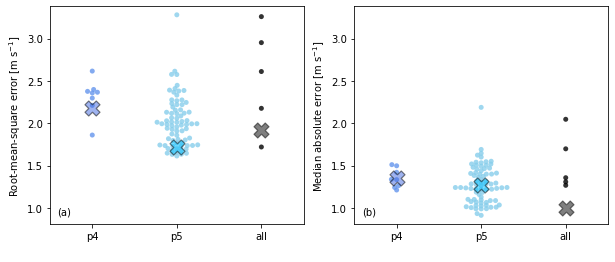

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
swarm2min = np.min([p45_metric_df_wfip2.melt(ignore_index=False).loc['mdae']['value'].min(), 
                   p45_metric_df_wfip2.melt(ignore_index=False).loc['rmse']['value'].min()])-0.1
swarm2max = np.max([p45_metric_df_wfip2.melt(ignore_index=False).loc['mdae']['value'].max(), 
                   p45_metric_df_wfip2.melt(ignore_index=False).loc['rmse']['value'].max()])+0.1
    
sns.swarmplot(x='t2', y='value', data=p45_metric_df_wfip2.melt(ignore_index=False).loc['rmse'], ax=ax1, alpha=0.8, 
              palette=select_p_color)
sns.swarmplot(x='t3', y='value', data=mean_metrics_wfip2.melt(ignore_index=False).loc['rmse'], edgecolor='k', 
              linewidth=1.2, marker='X', size=15, ax=ax1, palette=select_x_color, alpha=0.5)
ax1.set_ylabel(r'Root-mean-square error [m s$^{-1}$]')
ax1.set_xlabel(' ')
ax1.set_ylim(swarm2min, swarm2max)

sns.swarmplot(x='t2', y='value', data=p45_metric_df_wfip2.melt(ignore_index=False).loc['mdae'], ax=ax2, alpha=0.8, 
              palette=select_p_color)
sns.swarmplot(x='t3', y='value', data=mean_metrics_wfip2.melt(ignore_index=False).loc['mdae'], edgecolor='k', 
              linewidth=1.2, marker='X', size=15, ax=ax2, palette=select_x_color, alpha=0.5)
ax2.set_ylabel(r'Median absolute error [m s$^{-1}$]')
ax2.set_xlabel(' ')
ax2.set_ylim(swarm2min, swarm2max)

axt_x, axt_y = 0.03, 0.04
ax1.text(axt_x, axt_y, '(a)', transform=ax1.transAxes)
ax2.text(axt_x, axt_y, '(b)', transform=ax2.transAxes)

# plt.suptitle('wfip2 @ 80 m')

plt.savefig('../publication/plot/Fig4ab.pdf')
plt.savefig('../publication/plot/Fig4ab.eps')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


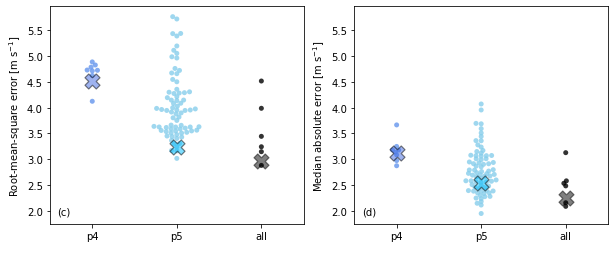

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

swarm2min = np.min([p45_metric_df_fino.melt(ignore_index=False).loc['mdae']['value'].min(), 
                   p45_metric_df_fino.melt(ignore_index=False).loc['rmse']['value'].min()])-0.2
swarm2max = np.max([p45_metric_df_fino.melt(ignore_index=False).loc['mdae']['value'].max(), 
                   p45_metric_df_fino.melt(ignore_index=False).loc['rmse']['value'].max()])+0.2

sns.swarmplot(x='t2', y='value', data=p45_metric_df_fino.melt(ignore_index=False).loc['rmse'], ax=ax1, alpha=0.8, 
              palette=select_p_color)
sns.swarmplot(x='t3', y='value', data=mean_metrics_fino.melt(ignore_index=False).loc['rmse'], edgecolor='k', 
              linewidth=1.2, marker='X', size=15, ax=ax1, palette=select_x_color, alpha=0.5)
ax1.set_ylabel(r'Root-mean-square error [m s$^{-1}$]')
ax1.set_xlabel(' ')
ax1.set_ylim(swarm2min, swarm2max)

sns.swarmplot(x='t2', y='value', data=p45_metric_df_fino.melt(ignore_index=False).loc['mdae'], ax=ax2, alpha=0.8, 
              palette=select_p_color)
sns.swarmplot(x='t3', y='value', data=mean_metrics_fino.melt(ignore_index=False).loc['mdae'], edgecolor='k', 
              linewidth=1.2, marker='X', size=15, ax=ax2, palette=select_x_color, alpha=0.5)
ax2.set_ylabel(r'Median absolute error [m s$^{-1}$]')
ax2.set_xlabel(' ')
ax2.set_ylim(swarm2min, swarm2max)

axt_x, axt_y = 0.03, 0.04
ax1.text(axt_x, axt_y, '(c)', transform=ax1.transAxes)
ax2.text(axt_x, axt_y, '(d)', transform=ax2.transAxes)

# plt.suptitle('fino2 @ 82 m')

plt.savefig('../publication/plot/Fig4cd.pdf')
plt.savefig('../publication/plot/Fig4cd.eps')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


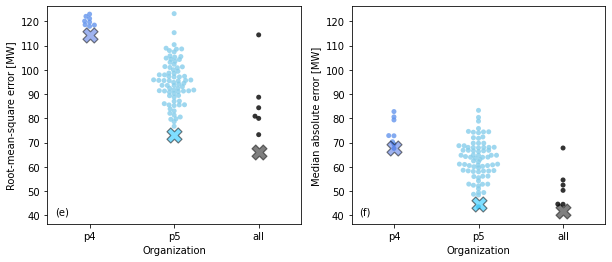

In [76]:
select_p_color = [p4_sclr, p5_sclr, 'k']
select_x_color = [p4_clr, p5_clr, 'k']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

swarm2min = np.min([p45_metric_df_baltic.melt(ignore_index=False).loc['mdae']['value'].min(), 
                   p45_metric_df_baltic.melt(ignore_index=False).loc['rmse']['value'].min()])-7
swarm2max = np.max([p45_metric_df_baltic.melt(ignore_index=False).loc['mdae']['value'].max(), 
                   p45_metric_df_baltic.melt(ignore_index=False).loc['rmse']['value'].max()])+3

sns.swarmplot(x='t2', y='value', data=p45_metric_df_baltic.melt(ignore_index=False).loc['rmse'], ax=ax1, alpha=0.8, 
              palette=select_p_color)
sns.swarmplot(x='t3', y='value', data=mean_metrics_baltic.melt(ignore_index=False).loc['rmse'], edgecolor='k', 
              linewidth=1.2, marker='X', size=15, ax=ax1, palette=select_x_color, alpha=0.5)
ax1.set_ylabel('Root-mean-square error [MW]')
ax1.set_xlabel('Organization')
ax1.set_ylim(swarm2min, swarm2max)

sns.swarmplot(x='t2', y='value', data=p45_metric_df_baltic.melt(ignore_index=False).loc['mdae'], ax=ax2, alpha=0.8, 
              palette=select_p_color)
sns.swarmplot(x='t3', y='value', data=mean_metrics_baltic.melt(ignore_index=False).loc['mdae'], edgecolor='k', 
              linewidth=1.2, marker='X', size=15, ax=ax2, palette=select_x_color, alpha=0.5)
ax2.set_ylabel('Median absolute error [MW]')
ax2.set_xlabel('Organization')
ax2.set_ylim(swarm2min, swarm2max)

axt_x, axt_y = 0.03, 0.04
ax1.text(axt_x, axt_y, '(e)', transform=ax1.transAxes)
ax2.text(axt_x, axt_y, '(f)', transform=ax2.transAxes)

plt.savefig('../publication/plot/Fig4ef.pdf')
plt.savefig('../publication/plot/Fig4ef.eps')

# plt.suptitle('baltic-2')
plt.show()

### fig 5

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


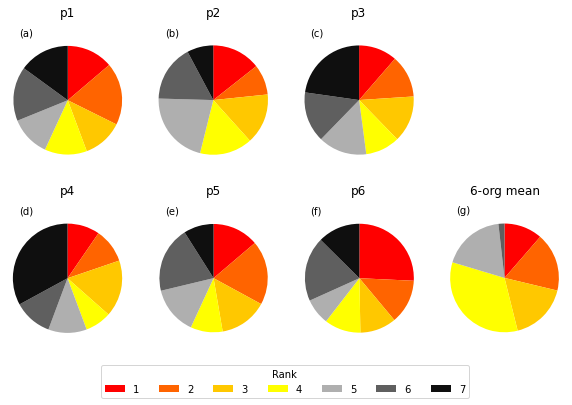

In [77]:
rankae_df = org_rankae_df

fig, ax = plt.subplots(2, 4, figsize=(10, 6))

unique_n = rankae_df.nunique().max()

color_n = math.ceil(unique_n/2)
gray_n = unique_n-color_n

colors = plt.get_cmap('autumn')(np.arange(color_n)*100)

grays = plt.get_cmap('gray_r')(np.arange(1, gray_n+1)*80)

ax = ax.ravel()

p_label_list = ['a', 'b', 'c', '', 'd', 'e', 'f', 'g']

for ind, org in zip([0,1,2,4,5,6,7], list(np.sort(rankae_df.columns)[1:])+[np.sort(rankae_df.columns)[0]]): 

    ranks_list = sorted(rankae_df[org].unique().astype(int))
#     ranks_list = sorted(rankae_df[org].unique())
#     print(ranks_list)

    rank_sum_list = []

    for r in ranks_list: 

        rank_sum_list.append((rankae_df[org] == r).sum())
        
#     print(org, rank_sum_list)

    patches, texts = ax[ind].pie(rank_sum_list, shadow=False, 
                                 startangle=90, counterclock=False, colors=np.concatenate((colors, grays)))

    ax[ind].axis('equal')

    if ind == 7:
        ax[ind].set_title('6-org mean', pad=10)
    else:
        ax[ind].set_title(org, pad=10)
    
    if ind == 6:
        ax[ind].legend(patches, ranks_list, ncol=len(ranks_list), bbox_to_anchor=(1.45, -0.05), 
                       title='Rank')
        
    ax[ind].text(0.1, 0.94, '('+p_label_list[ind]+')', transform=ax[ind].transAxes)
    
fig.delaxes(ax[3])

# labels = ['1', '2', '3', '4', '5', '6']
# plt.legend(patches, labels, ncol=6)

# plt.suptitle('baltic2 power forecast: rank of absolute error')
# plt.tight_layout()

plt.savefig('../publication/plot/Fig5.pdf')
plt.savefig('../publication/plot/Fig5.eps')

plt.show()

### fig 6

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


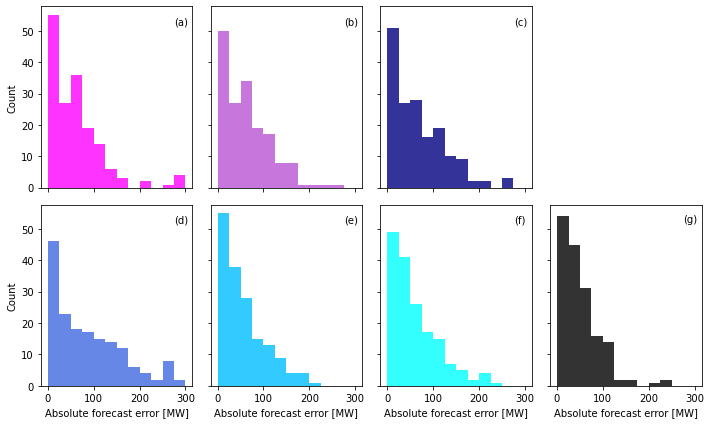

In [78]:
al_pha = 0.8

fig, ax = plt.subplots(2, 4, figsize=(10, 6), sharex=True, sharey=True)

ax = ax.ravel()
oad_max = int(math.ceil(org_ae_df.max().max()))
phist_ymax = 60

binlist = np.arange(0, 301, 25) 
# binlist = np.arange(0, oad_max, 25)

p_label_list = ['a', 'b', 'c', '', 'd', 'e', 'f', 'g']

def plot_aehist(ax, ind, name, c):
    ax = ax[ind]
    org_ae_df[name].hist(alpha=al_pha, ax=ax, bins=binlist, color=c)
    if name == 'avg':
        name = '5-org avg'
#     ax.set_title(name)
    ax.text(0.88, 0.9, '('+p_label_list[ind]+')', transform=ax.transAxes)
    ax.grid(False)
    
plot_aehist(ax, 0, 'p1', p1_clr)
plot_aehist(ax, 1, 'p2', p2_clr)
plot_aehist(ax, 2, 'p3', p3_clr)
plot_aehist(ax, 4, 'p4', p4_clr)
plot_aehist(ax, 5, 'p5', p5_clr)
plot_aehist(ax, 6, 'p6', p6_clr)
plot_aehist(ax, 7, 'avg', 'k')

ax[0].set_ylabel('Count')
ax[4].set_ylabel('Count')

ax[4].set_xlabel('Absolute forecast error [MW]')
ax[5].set_xlabel('Absolute forecast error [MW]')
ax[6].set_xlabel('Absolute forecast error [MW]')
ax[7].set_xlabel('Absolute forecast error [MW]')

fig.delaxes(ax[3])

plt.tight_layout()

plt.savefig('../publication/plot/Fig6.pdf')
plt.savefig('../publication/plot/Fig6.eps')

plt.show()

### fig 7

p4m 4336.326309808886


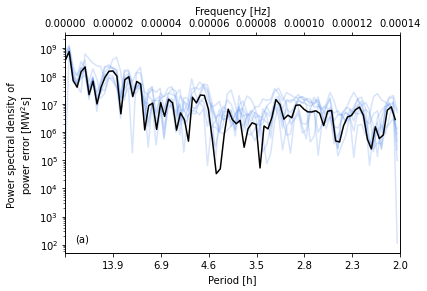

In [83]:
df_p4 = read_ts_df('baltic-power', 'p4', sub='60min')
df_p4.dropna(inplace=True)
df_p4 = df_p4['78.25']

means_ts = read_ts_df('baltic-power/allmeans', 'allmeans', sub='60min')
means_ts.dropna(inplace=True)
means_ts = means_ts['78.25']

def plot_sq_p_error_spectrum_p4(p, p_color, thres, alpha=0.3):
    
    p_diff = (df_p4[p][p+'_power'] - df_p4['p4-1']['baltic_power'])

    freq, power = welch(p_diff.values, fs=1/3600, nperseg=len(p_diff))
        
    plt.plot(freq, power, label='_nolegend_', c=p_color, alpha=alpha)
    
    integral = scipy.integrate.cumtrapz(power, freq, initial=0)[-1]
    
    if integral < thres:
        print(p, integral)
    
    return freq, power

fig, ax = plt.subplots()
ax2 = ax.twiny()

p_diff_m = means_ts['p4m']['p4m_power'] - means_ts['p4m']['baltic_power']

freq_m, power_m = welch(p_diff_m.values, fs=1/3600, nperseg=len(p_diff_m))

print('p4m', scipy.integrate.cumtrapz(power_m, freq_m, initial=0)[-1])

p4m_intg = scipy.integrate.cumtrapz(power_m, freq_m, initial=0)[-1]

for mem in df_p4.columns.get_level_values(0).unique():

    freq, power = plot_sq_p_error_spectrum_p4(mem, p4_sclr, p4m_intg, alpha=0.25)

plt.plot(freq_m, power_m, label='p4 mean', c='k', alpha=1)

# ax.set_xscale('log')
ax.set_yscale('log')
ax2.set_xlim(0, 1/(119*60))

with np.errstate(divide='ignore'):
    bottom_xticks = list(np.round(1/ax2.get_xticks()/3600, 1))
bottom_xticks = [str(i) for i in bottom_xticks]
bottom_xticks[0] = ''

ticks_loc = np.linspace(0, 1, 8)
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels(bottom_xticks[:-1])
ax2.set_xlabel('Frequency [Hz]')
ax.set_xlabel('Period [h]')
ax.set_ylabel(r'Power spectral density of''\n''power error [MW${^2}$s]')
# plt.title('Squared power error power spectrum of p4 ensemble members and mean')

# plt.legend()

ax.text(0.03, 0.05, '(a)', transform=ax.transAxes)

plt.show()

p5m 3776.2827082827494
p5-13 3637.538281303584
p5-29 3322.2860408329047
p5-37 3607.9943653395494
p5-49 3514.07698705686
p5-61 3626.740893270075


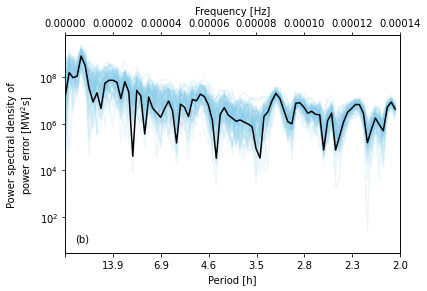

In [84]:
df_p5 = read_ts_df('baltic-power', 'p5', sub='60min')
df_p5.dropna(inplace=True)
df_p5 = df_p5['78.25']

def plot_sq_p_error_spectrum_p5(p, p_color, thres, alpha=0.3):
    
    p_diff = (df_p5[p][p+'_power'] - df_p5['p5-1']['baltic_power'])
    
    # hourly data for fs
    # nperseg is analysis period divided by dt
    freq, power = welch(p_diff.values, fs=1/3600, nperseg=len(p_diff))
        
    plt.plot(freq, power, label='_nolegend_', c=p_color, alpha=alpha)
    
    integral = scipy.integrate.cumtrapz(power, freq, initial=0)[-1]
    
    if integral < thres:
        print(p, integral)
    
    return freq, power

fig, ax = plt.subplots()
ax2 = ax.twiny()

p_diff_m = means_ts['p5m']['p5m_power'] - means_ts['p5m']['baltic_power']

freq_m, power_m = welch(p_diff_m.values, fs=1/3600, nperseg=len(p_diff_m))

print('p5m', scipy.integrate.cumtrapz(power_m, freq_m, initial=0)[-1])

p5m_intg = scipy.integrate.cumtrapz(power_m, freq_m, initial=0)[-1]

for mem in df_p5.columns.get_level_values(0).unique():

    freq, power = plot_sq_p_error_spectrum_p5(mem, p5_sclr, p5m_intg, alpha=0.15)

plt.plot(freq_m, power_m, label='p5 mean', c='k', alpha=1)

# ax.set_xscale('log')
ax.set_yscale('log')
ax2.set_xlim(0, 1/(119*60))

with np.errstate(divide='ignore'):
    bottom_xticks = list(np.round(1/ax2.get_xticks()/3600, 1))
bottom_xticks = [str(i) for i in bottom_xticks]
bottom_xticks[0] = ''

ticks_loc = np.linspace(0, 1, 8)
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels(bottom_xticks[:-1])

ax2.set_xlabel('Frequency [Hz]')
ax.set_xlabel('Period [h]')
ax.set_ylabel(r'Power spectral density of''\n''power error [MW${^2}$s]')
# plt.title('Squared power error power spectrum of p5 ensemble members and mean')

# plt.legend()

ax.text(0.03, 0.05, '(b)', transform=ax.transAxes)

plt.show()

p1 4118.446401958245
p2 4647.966097656431
p3 6053.020144656736
p4 4336.326309808886
p5 3776.2827082827494
p6 3689.5488110707397
all 2352.5822293893516


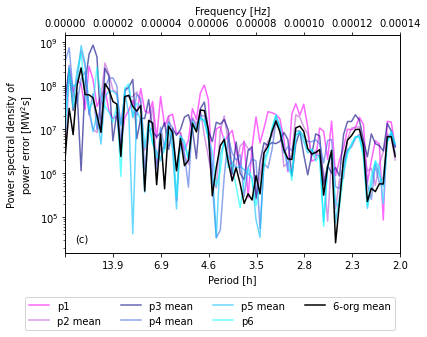

In [85]:
def plot_sq_p_error_spectrum(p, p_color, alpha=0.6, label=None):
    
    p_diff = (means_ts[p+'m'][p+'m_power'] - means_ts['p1m']['baltic_power'])
    
    # hourly data for fs
    # nperseg is analysis period divided by dt
    # use a smaller nperseg could give better results 
    # according to https://stackoverflow.com/questions/65725179/usage-of-signal-welch
    # result should be power spectral density
    freq, power = welch(p_diff, fs=1/3600, nperseg=len(p_diff))
    
    # integrate area should = np.sum(p_diff**2)
    # integration function is not exact
    # need to multiply by len(p_diff) to get the right magnitude?
    print(p, scipy.integrate.cumtrapz(power, freq, initial=0)[-1])
    
    if label is None:
        plt.plot(freq, power, label=p, c=p_color, alpha=alpha)
    else:
        plt.plot(freq, power, label=label, c=p_color, alpha=alpha)
    
    return freq, power

fig, ax = plt.subplots()
ax2 = ax.twiny()

freq, power = plot_sq_p_error_spectrum('p1', p1_clr)
freq, power = plot_sq_p_error_spectrum('p2', p2_clr, label='p2 mean')
freq, power = plot_sq_p_error_spectrum('p3', p3_clr, label='p3 mean')
freq, power = plot_sq_p_error_spectrum('p4', p4_clr, label='p4 mean')
freq, power = plot_sq_p_error_spectrum('p5', p5_clr, label='p5 mean')
freq, power = plot_sq_p_error_spectrum('p6', p6_clr)
freq, power = plot_sq_p_error_spectrum('all', 'k', alpha=1, label='6-org mean')

# ax.set_xscale('log')
ax.set_yscale('log')
ax2.set_xlim(0, 1/(119*60))

# ax2.set_xlim(ax.get_xlim())
# ax2.set_yscale('log')

# ax2.set_xlim(ax.get_xlim())
# ax.set_xticklabels([0, 10, 20, 30, 40, 50])

# label_format = '{:,.0f}'

# print(ax.get_xticks())
# print(ax2.get_xticks())
# print(ax.get_xticklabels())
# print(ax2.get_xticklabels())

# t_xtick = ['']
# for xtick in ax2.get_xticklabels()[1:]:
#     print(xtick)
#     t = np.round(1/float(xtick.get_text())/3600, 1)
#     t_xtick.append(str(t))

with np.errstate(divide='ignore'):
    bottom_xticks = list(np.round(1/ax2.get_xticks()/3600, 1))
bottom_xticks = [str(i) for i in bottom_xticks]
bottom_xticks[0] = ''

ticks_loc = np.linspace(0, 1, 8)
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels(bottom_xticks[:-1])

ax2.set_xlabel('Frequency [Hz]')
ax.set_xlabel('Period [h]')
ax.set_ylabel(r'Power spectral density of''\n''power error [MW${^2}$s]')
# plt.title('Squared power error power spectrum of 5 organizations and mean')

plt.legend(bbox_to_anchor=(1., -0.18), ncol=4)

ax.text(0.03, 0.05, '(c)', transform=ax.transAxes)

# plt.savefig('../publication/plot/Fig7c.pdf')
# plt.savefig('../publication/plot/Fig7c.eps')

plt.show()

### fig 8

/Users/josephlee/Documents/others/WE-Validate/output/60min/baltic-power/allmeans/ramp_allmeans.csv
Index(['true_positive', 'false_positive', 'false_negative', 'true_negative'], dtype='object')


/var/folders/qs/23vzfzq165z2dsx3srgfx21r0000gn/T/ipykernel_16581/1649889922.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_srdf = p_srdf.append(p_srdf.iloc[0]).iloc[1:]


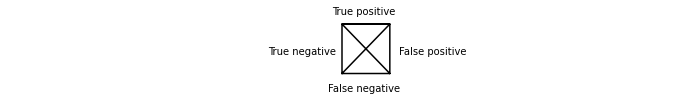

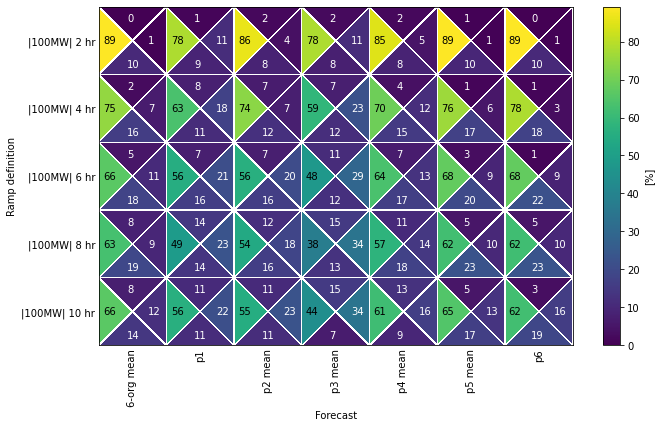

In [14]:
def get_2x2_allmeanramps_plot(case, lev):

    lev = str(lev)

    rdf = get_allmean_rampdf(case, 4)
    
    mw_list = [s for s in rdf.columns.get_level_values(-1).unique() 
                     if ('_100MW' in s)]
#     mw_list = [s for s in rdf.columns.get_level_values(-1).unique() 
#                      if ('_50MW' in s) or ('_100MW' in s) and ('_100MW_2' not in s) and ('_100MW_4' not in s)]
    
    rdf = rdf.loc(axis=1)[:, :, :, :, mw_list]
    
    inds = ['true_positive', 'false_positive', 'false_negative', 'true_negative']
    
    rdf_2x2 = rdf.loc(axis=1)[lev, :, :, 'all', : ,:].loc[inds]

    rdf_2x2 = rdf_2x2.xs('all', level=3, axis=1, drop_level=True)
    
    d1 = dict(zip(rdf_2x2.columns.levels[1], rdf_2x2.columns.levels[1].str.replace('m', ' mean')))

    d1['allm'] = '6-org mean'
    d1['p1m'] = 'p1'
    d1['p6m'] = 'p6'

    rdf_2x2 = rdf_2x2.rename(columns=d1, level=1)
    
    d2 = dict(zip(rdf_2x2.columns.levels[-1], rdf_2x2.columns.levels[-1].str.replace(
        'r_abs_magnitude_', '|').str.replace('_', '| ').str.replace('hours', 'hr')))

    rdf_2x2 = rdf_2x2.rename(columns=d2, level=-1)

#     rdf_2x2.columns.levels[1].str.replace('m', ' mean')
#     srdf = rdf_2x2.T
    
    rdf_pct = 100*rdf_2x2/rdf_2x2.sum()
    srdf = rdf_pct.T

    srdf.index.set_names(['t1', 't2', 't3', 't4'], inplace=True)
    p_srdf = srdf.pivot_table(index='t4', columns='t2')
    # reorganize rows
    p_srdf = p_srdf.append(p_srdf.iloc[0]).iloc[1:]
    
#     p_srdf.columns.levels[-1] = p_srdf.columns.levels[-1].str.replace('m', ' mean')
#     p_srdf.columns.levels[-1] = p_srdf.columns.levels[-1].str.replace('_', ' ')
#     p_srdf.columns.levels[-1] = p_srdf.columns.levels[-1].str.replace('all', 'all 5p')
    
    plot_2x2(p_srdf, srdf, plot_allramps_contin_legend, 
             case+' case: 2x2 contingency table percentage at '+lev+' m')
    
    return rdf, rdf_2x2, srdf, p_srdf
    
def get_allmean_rampdf(case, head_num):
    
    head_num = 4

#     file_list = glob.glob(main_dir+'output/'+case+'/ramp_*.csv')
    file = main_dir+'output/60min/'+case+'/allmeans/ramp_allmeans.csv'
    print(file)
#     file = main_dir+'output/allmeans_60min/ramp_allmeans.csv'
    
    rdf = pd.read_csv(file, header=list(range(0, head_num+1)), index_col=[0])
#     print(rdf.columns.get_level_values(2).unique())
            
    return rdf

def plot_2x2(ps_df, s_df, legend, title_txt, log=False):
    
    m = len(ps_df.columns) // 4
    n = len(ps_df)
    values = [ps_df.sort_index(axis=1)[col] for col in s_df.columns]  # these are the 4 column names in df

    triangul = triangulation_for_triheatmap(m, n)
    
    cmaps = ['viridis'] * 4
    if log is False:
        norms = [plt.Normalize(ps_df.min().min(), ps_df.max().max()) for _ in range(4)]
    elif log is True: 
        # log(0) is nan and crashes plotting code
        ps_df.replace(0, 1, inplace=True)
        norms = [colors.LogNorm(ps_df.min().min(), ps_df.max().max()) for _ in range(4)]
        
    legend(s_df.columns)
    
#     fig, (axl, ax) = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={'height_ratios': [1, 3]})
    fig, ax = plt.subplots(figsize=(10, 6))

    imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, norm=norm, ec='white', visible=True)
            for t, val, cmap, norm in zip(triangul, values, cmaps, norms)]
    # imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, ec='white')
    #         for t, val, cmap in zip(triangul, values, cmaps)]

    norm_df = np.round((s_df.T/s_df.T.sum()).T*100).astype(int)

    t4_list = ['|100MW| 10 hr', '|100MW| 8 hr', '|100MW| 6 hr', '|100MW| 4 hr', '|100MW| 2 hr']

    y_tp, y_tn, y_fn, y_fp = 0.155, 0.09, 0.02, 0.09
    for t4_i in t4_list:
        sel_df = norm_df.loc[norm_df.index.get_level_values('t4') == t4_i].sort_values(by='t2')
        for i in range(len(sel_df)):
            ax.text(0.06+i*0.142, y_tp, sel_df['true_positive'][i], transform=ax.transAxes, c='white')
            ax.text(0.01+i*0.1425, y_tn, sel_df['true_negative'][i], transform=ax.transAxes, c='black')
            ax.text(0.06+i*0.142, y_fn, sel_df['false_negative'][i], transform=ax.transAxes, c='white')
            ax.text(0.105+i*0.1425, y_fp, sel_df['false_positive'][i], transform=ax.transAxes, c='white')
        y_tp += 0.2
        y_tn += 0.2
        y_fn += 0.2
        y_fp += 0.2

#     sel_df = norm_df.loc[norm_df.index.get_level_values('t4') == '|100MW| 10 hr'].sort_values(by='t2')
# #     print(sel_df)
#     for i in range(len(sel_df)):
#         ax.text(0.06+i*0.142, 0.155, sel_df['true_positive'][i], transform=ax.transAxes, c='white')
#         ax.text(0.01+i*0.1425, 0.09, sel_df['true_negative'][i], transform=ax.transAxes, c='black')
#         ax.text(0.06+i*0.142, 0.02, sel_df['false_negative'][i], transform=ax.transAxes, c='white')
#         ax.text(0.105+i*0.142, 0.09, sel_df['false_positive'][i], transform=ax.transAxes, c='white')
    
#     sel_df = norm_df.loc[norm_df.index.get_level_values('t4') == '|100MW| 8 hr'].sort_values(by='t2')
#     for i in range(len(sel_df)):
#         ax.text(0.068+i*0.166, 0.355, sel_df['true_positive'][i], transform=ax.transAxes, c='white')
#         ax.text(0.011+i*0.1665, 0.29, sel_df['true_negative'][i], transform=ax.transAxes, c='black')
#         ax.text(0.068+i*0.166, 0.22, sel_df['false_negative'][i], transform=ax.transAxes, c='white')
#         ax.text(0.119+i*0.167, 0.29, sel_df['false_positive'][i], transform=ax.transAxes, c='white')
        
#     sel_df = norm_df.loc[norm_df.index.get_level_values('t4') == '|100MW| 6 hr'].sort_values(by='t2')
#     for i in range(len(sel_df)):
#         ax.text(0.068+i*0.166, 0.555, sel_df['true_positive'][i], transform=ax.transAxes, c='white')
#         ax.text(0.011+i*0.1665, 0.49, sel_df['true_negative'][i], transform=ax.transAxes, c='black')
#         ax.text(0.068+i*0.166, 0.42, sel_df['false_negative'][i], transform=ax.transAxes, c='white')
#         ax.text(0.119+i*0.167, 0.49, sel_df['false_positive'][i], transform=ax.transAxes, c='white')
        
#     sel_df = norm_df.loc[norm_df.index.get_level_values('t4') == '|100MW| 4 hr'].sort_values(by='t2')
#     for i in range(len(sel_df)):
#         ax.text(0.068+i*0.166, 0.755, sel_df['true_positive'][i], transform=ax.transAxes, c='white')
#         ax.text(0.011+i*0.1665, 0.69, sel_df['true_negative'][i], transform=ax.transAxes, c='black')
#         ax.text(0.068+i*0.166, 0.62, sel_df['false_negative'][i], transform=ax.transAxes, c='white')
#         ax.text(0.119+i*0.167, 0.69, sel_df['false_positive'][i], transform=ax.transAxes, c='white')
        
#     sel_df = norm_df.loc[norm_df.index.get_level_values('t4') == '|100MW| 2 hr'].sort_values(by='t2')
#     for i in range(len(sel_df)):
#         ax.text(0.071+i*0.1668, 0.955, sel_df['true_positive'][i], transform=ax.transAxes, c='white')
#         ax.text(0.011+i*0.1665, 0.89, sel_df['true_negative'][i], transform=ax.transAxes, c='black')
#         ax.text(0.068+i*0.166, 0.82, sel_df['false_negative'][i], transform=ax.transAxes, c='white')
#         ax.text(0.119+i*0.167, 0.89, sel_df['false_positive'][i], transform=ax.transAxes, c='white')

    ax.tick_params(length=0)
    ax.set_xticks(range(m))
    ax.set_xticklabels(sorted(s_df.index.get_level_values(1).unique()), rotation=90)
    ax.set_yticks(range(n))
    ax.set_yticklabels(ps_df.index)
    ax.invert_yaxis()
    ax.margins(x=0, y=0)
    ax.set_aspect('equal', 'box')  # square cells
    plt.colorbar(imgs[3], ax=ax, label='[%]')
#     ax.set_title(title_txt, pad=8)
    ax.set_ylabel('Ramp definition')
    ax.set_xlabel('Forecast')
    
    plt.tight_layout()

    plt.savefig('../publication/plot/Fig8.pdf', bbox_inches='tight')
    plt.savefig('../publication/plot/Fig8.eps', bbox_inches='tight')

    plt.show()
    
def triangulation_for_triheatmap(m, n):
    
    xv, yv = np.meshgrid(np.arange(-0.5, m), np.arange(-0.5, n))  # vertices of the little squares
    xc, yc = np.meshgrid(np.arange(0, m), np.arange(0, n))  # centers of the little squares
    x = np.concatenate([xv.ravel(), xc.ravel()])
    y = np.concatenate([yv.ravel(), yc.ravel()])
    cstart = (m+1)*(n+1)  # indices of the centers

    triangles_top = [(i+j * (m+1), i+1+j * (m+1), cstart+i+j*m)
                  for j in range(n) for i in range(m)]
    triangles_right = [(i+1+j * (m+1), i+1+(j+1) * (m+1), cstart+i+j*m)
                  for j in range(n) for i in range(m)]
    triangles_bot = [(i+1+(j+1) * (m+1), i+(j+1) * (m+1), cstart+i+j*m)
                  for j in range(n) for i in range(m)]
    triangles_left = [(i+(j+1) * (m+1), i+j * (m+1), cstart+i+j*m)
                  for j in range(n) for i in range(m)]
    
    return [Triangulation(x, y, triangles) 
            for triangles in [triangles_top, triangles_right, triangles_bot, triangles_left]]
    
def plot_allramps_contin_legend(txt_list):

    fig, ax = plt.subplots(figsize=(12, 1))

    ax.plot((0, 0, 1, 1, 0, 1, 0, 1), (0, 1, 1, 0, 0, 1, 1, 0), c='k')

    print(txt_list)

    ax.set_xlim(-7, 7)
    # ax.text(-1.55, 0.4, txt_list[3], c='k')
    # ax.text(-0.2, 1.2, txt_list[0], c='k')
    # ax.text(1.2, 0.4, txt_list[1], c='k')
    # ax.text(-0.3, -0.35, txt_list[2], c='k')

    ax.text(-1.55, 0.4, 'True negative', c='k')
    ax.text(-0.2, 1.2, 'True positive', c='k')
    ax.text(1.2, 0.4, 'False positive', c='k')
    ax.text(-0.3, -0.35, 'False negative', c='k')

    ax.axis(False) # set to True to see where to put plot

    plt.savefig('../publication/plot/Fig8legend.pdf', bbox_inches='tight')
    plt.savefig('../publication/plot/Fig8legend.eps', bbox_inches='tight')

    plt.show()

rdf, rdf_2x2, srdf, p_srdf = get_2x2_allmeanramps_plot('baltic-power', 78.25)

### fig 9

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


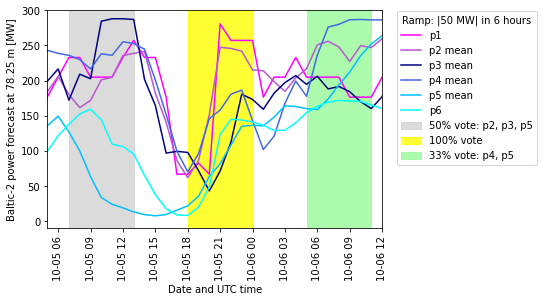

In [35]:
al_pha = 1

colormap = plt.cm.gist_ncar

fig, ax = plt.subplots()

mem_lw = 1.5

# p_color = ['magenta', 'mediumorchid', 'navy', 'royalblue', 'deepskyblue', 'cyan']

ax.plot(df_p1.index, df_p1[lev]['p1']['p1_power'], label='p1', c=p1_clr, linewidth=mem_lw)

ax.plot(df_p2_sum.index, df_p2_sum[lev]['mean'], c=p2_clr, label='p2 mean', alpha=al_pha, linewidth=mem_lw)

ax.plot(df_p3_sum.index, df_p3_sum[lev]['mean'], c=p3_clr, label='p3 mean', alpha=al_pha, linewidth=mem_lw)

ax.plot(df_p4_sum.index, df_p4_sum[lev]['mean'], c=p4_clr, label='p4 mean', alpha=al_pha, linewidth=mem_lw)

ax.plot(df_p5_sum.index, df_p5_sum[lev]['mean'], c=p5_clr, label='p5 mean', alpha=al_pha, linewidth=mem_lw)

ax.plot(df_p6.index, df_p6[lev]['p6-1']['p6-1_power'], label='p6', c=p6_clr, linewidth=mem_lw)

# ax.plot(org_mean_alllev_df.index, org_mean_alllev_df[lev], label='avg', c='k', linewidth=1.5)

# ax.plot(df_p1.index, df_p1[lev]['p1']['baltic_power'], label='obs', c='red', linewidth=1.2)

ax.fill_between(df_p4_sum.index[32:39], -100, 400, color='lightgrey', 
                label='50% vote: p2, p3, p5', alpha=al_pha-0.2)

ax.fill_between(df_p4_sum.index[43:50], -100, 400, color='yellow', 
                label='100% vote', alpha=al_pha-0.2)

ax.fill_between(df_p4_sum.index[54:61], -100, 400, color='palegreen', 
                label='33% vote: p4, p5', alpha=al_pha-0.2)

var_txt = 'Baltic-2 power forecast at '+lev+' m'

plt.xticks(rotation=90)
plt.ylim((-10, 300))

plt.xlim((df_p1.index[30], df_p1.index[61]))

plt.xlabel('Date and UTC time')
plt.ylabel(var_txt+r' [MW]')
# plt.title(case+' case: '+var_txt)
plt.legend(bbox_to_anchor=(1.03, 1.02), loc='upper left', title='Ramp: |50 MW| in 6 hours')

plt.savefig('../publication/plot/Fig9.pdf', bbox_inches='tight')
plt.savefig('../publication/plot/Fig9.eps', bbox_inches='tight')

plt.show()

### figs 10-15

In [15]:
def get_allmeans_ramp_dfs(lev): 

    case_dir = 'output/60min/baltic-power/allmeans/'

    rampts_df = pd.read_csv(main_dir+case_dir+'ramp_ts_allmeans.csv', 
                            header=[0, 1, 2, 3, 4, 5], index_col=[0], low_memory=False)
    # df.columns = df.columns.set_levels(
    #       df.columns.levels[1].astype(int), level=1
    # )
    rampts_df.index = pd.to_datetime(rampts_df.index)

    head_num = 4

    file = main_dir+case_dir+'ramp_allmeans.csv'

    ramp_metrics_df = pd.read_csv(file, header=list(range(0, head_num+1)), index_col=[0])

    rampts_allmems_df = rampts_df[lev].drop('allm', axis=1, level=0)

    num_orgs = len(rampts_allmems_df.columns.get_level_values(0).unique())

#     vote_thres_dict = {'80%': 0.8, '60%': 0.6, '40%': 0.4, '20%': 0.2}
    vote_thres_dict = {'83%': 0.83, '66%': 0.66, '50%': 0.5, '33%': 0.33, '16%': 0.16}

    for ramp_method in rampts_allmems_df.xs('comp_ramp', level=4, axis=1).columns.get_level_values(-1).unique(): 

    #     print(ramp_method)

        comp_ramps_df = rampts_allmems_df.xs('comp_ramp', level=4, axis=1).xs(ramp_method, level=-1, axis=1)

        for key, val in vote_thres_dict.items():

    #         print(val)

            simpleramp_df = pd.DataFrame(0, index=rampts_allmems_df.index, 
                                         columns=['base_ramp', 'comp_ramp']).astype(float)

            simpleramp_df['base_ramp'] = rampts_allmems_df.xs('base_ramp', level=4, axis=1).xs(
                ramp_method, level=-1, axis=1).xs(
                'p1m', level=0, axis=1).values

            for index, row in comp_ramps_df.iterrows():

    #             print(row.values)
    #             print(row.isnull().all())

    #             print(np.nansum(row.values) >= num_orgs*val)

                # vote
                if np.nansum(row.values) >= num_orgs*val:

    #                 print(np.nansum(row.values))

                    simpleramp_df.at[index, 'comp_ramp'] = 1

                if row.isnull().all():

                    simpleramp_df.at[index, 'comp_ramp'] = np.nan

            simpleramp_df.dropna(subset=['base_ramp', 'comp_ramp'], inplace=True)

            process_ramp = eval_tools.get_module_class('ramps', 'process_ramp')(simpleramp_df)
            ramp2b2_df = process_ramp.add_contingency_table()
            ramp_1summary_df = process_ramp.generate_ramp_summary_df()

            ramp2b2_df.columns = pd.MultiIndex.from_product([[lev], [key+'_vote'], [key+'_vote'],
                                                      [rampts_df.columns.get_level_values(3).unique()[0]], 
                                                      [ramp_method], ramp2b2_df.columns]
                                                    )

            rampts_df = rampts_df.join(ramp2b2_df)

            ramp_1summary_df.columns = pd.MultiIndex.from_product([[lev], [key+'_vote'], [key+'_vote'],
                                                      [rampts_df.columns.get_level_values(3).unique()[0]], 
                                                      [ramp_method]]
                                                    )

            ramp_metrics_df = ramp_metrics_df.join(ramp_1summary_df)
            
    return rampts_df, ramp_metrics_df

rampts_df_allm, ramp_metrics_df_allm = get_allmeans_ramp_dfs('78.25')

In [26]:
def plot_rampmetric_heatmaps(ramp_metrics_df, org, inds, fig_num, cbar_title, 
                             vote_thres_dict={'83%': 0.83, '66%': 0.66, '50%': 0.5, '33%': 0.33, '16%': 0.16}):

#     print(vote_thres_dict)

    if org == 'all':
        col_list = list(ramp_metrics_df.columns.get_level_values(1).unique())
    else: 
        col_list = [org+'m']+list({f'{k}_vote': v for k, v in vote_thres_dict.items()}.keys())
        
#     print(col_list)
    
    ramp_metrics_df_sel = ramp_metrics_df.loc(axis=1)[lev, col_list, :, 'all', : ,:]

    rdf_2x2 = ramp_metrics_df_sel.loc[inds]

    rdf_2x2 = rdf_2x2.xs('all', level=3, axis=1, drop_level=True)
    
    d = dict(zip(rdf_2x2.columns.levels[-1], rdf_2x2.columns.levels[-1].str.replace(
        'r_abs_magnitude_', '|').str.replace('_', '| ').str.replace('hours', 'hr')))

    rdf_2x2 = rdf_2x2.rename(columns=d, level=-1)

    srdf = rdf_2x2.T
    srdf.index.set_names(['t1', 't2', 't3', 't4'], inplace=True)
    
    for i in inds:

        fig, ax = plt.subplots(figsize=(10, 8))

        plot_df = srdf[[i]].unstack().T.sort_index()
#         plot_df = plot_df.reindex(list(plot_df.index[-6:])+list(plot_df.index[:-6]))
        plot_df = plot_df.xs(i, level=0, axis=0, drop_level=True)
        
        plot_df.columns = plot_df.columns.droplevel(0)
        plot_df.columns = plot_df.columns.droplevel(-1)
        
#         print(plot_df.columns)
        plot_df.rename(columns={'p1m': 'p1'}, inplace=True)
        plot_df.rename(columns={'p6m': 'p6'}, inplace=True)
        plot_df.columns = plot_df.columns.str.replace('m', ' mean')
        plot_df.columns = plot_df.columns.str.replace('_', ' ')
        plot_df.columns = plot_df.columns.str.replace('all', '6-org')
        
        ramp_def_list = []
        
        for mw, hr in itertools.product(np.arange(50, 201, 50), np.arange(2, 13, 2)):
       
            if (mw > 100) & (hr == 2):
                pass
            elif (mw == 50) & (hr == 10):
                pass
            elif (mw <= 100) & (hr == 12):
                pass
            else:
                ramp_def_list.append('|'+str(mw)+'MW| '+str(hr)+' hr')
        
        plot_df = plot_df.reindex(ramp_def_list)
        
        if org != 'all':
            plot_df = plot_df.reindex(
                columns=list(plot_df.columns[1:-2])+list(plot_df.columns[:1])+list(plot_df.columns[-1:]))

        if (i == 'symmetric_extreme_dependency_score') or (i == 'peirces_skill_score'):

            rdgn = sns.diverging_palette(h_neg=240, h_pos=10, s=99, l=55, sep=3, as_cmap=True)
            p = sns.heatmap(plot_df, cmap=rdgn, center=0.0, annot=True, fmt ='.1g', 
                              cbar=True, ax=ax, cbar_kws={'label': cbar_title})

        else: 

            p = sns.heatmap(plot_df, ax=ax, annot=True, fmt='.3g', cmap='viridis', cbar_kws={'label': cbar_title})

#         p.set_title(i)
        print(i)



        p.set_ylabel('Ramp definition')
        p.set_xlabel('Forecast')

        plt.tight_layout()

        plt.savefig(f'../publication/plot/Fig{str(fig_num)}.pdf', bbox_inches='tight')
        plt.savefig(f'../publication/plot/Fig{str(fig_num)}.eps', bbox_inches='tight')

        plt.show()
        
    return srdf, rdf_2x2, plot_df

true_positive


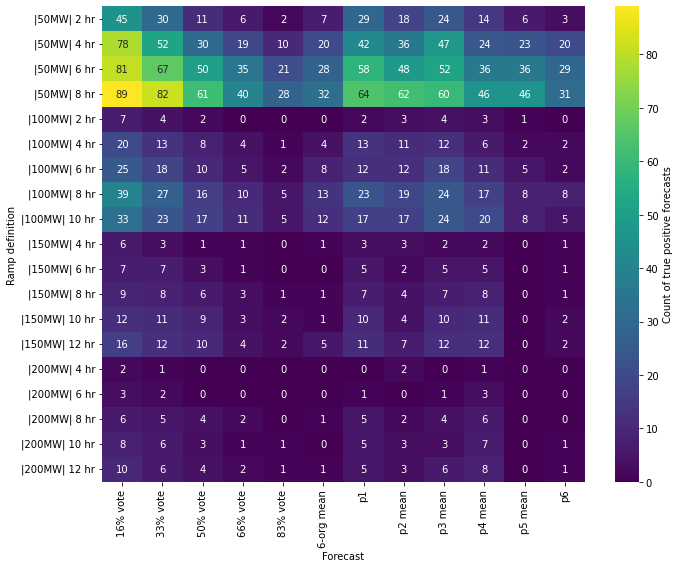

In [27]:
# inds = ['probability_of_detection', 'forecast_accuracy', 'critical_success_index', 
#         'symmetric_extreme_dependency_score', 'peirces_skill_score', 
#         'true_positive', 'false_positive', 'false_negative', 'true_negative']
inds = ['true_positive']
fig_num = 10
cbar_title = 'Count of true positive forecasts'

srdf, rdf_2x2, plot_df = plot_rampmetric_heatmaps(ramp_metrics_df_allm, 'all', inds, fig_num, cbar_title)

false_positive


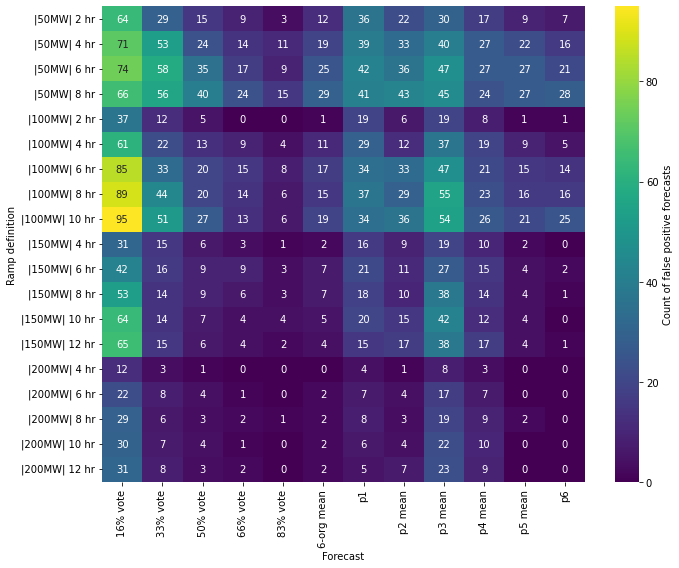

In [29]:
inds = ['false_positive']
fig_num = 11
cbar_title = 'Count of false positive forecasts'

srdf, rdf_2x2, plot_df = plot_rampmetric_heatmaps(ramp_metrics_df_allm, 'all', inds, fig_num, cbar_title)

false_negative


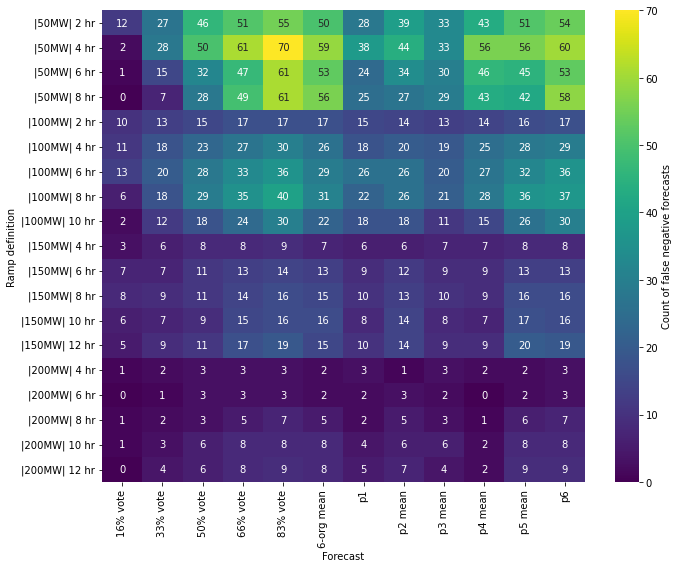

In [30]:
inds = ['false_negative']
fig_num = 12
cbar_title = 'Count of false negative forecasts'

srdf, rdf_2x2, plot_df = plot_rampmetric_heatmaps(ramp_metrics_df_allm, 'all', inds, fig_num, cbar_title)

true_negative


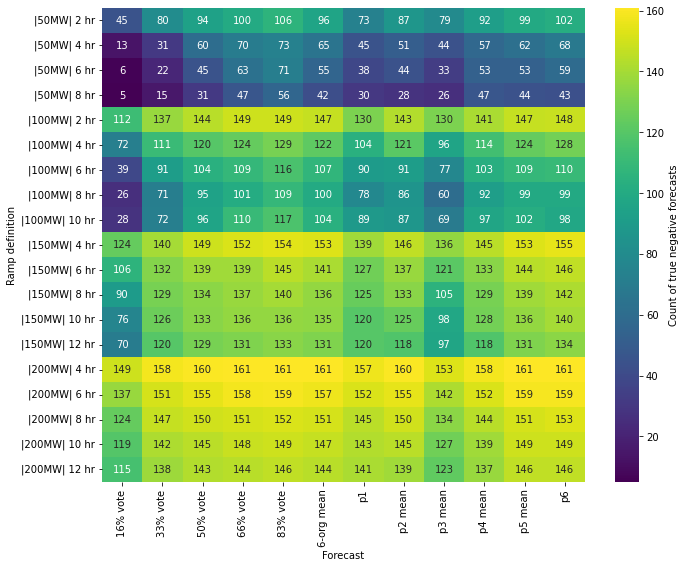

In [31]:
inds = ['true_negative']
fig_num = 13
cbar_title = 'Count of true negative forecasts'

srdf, rdf_2x2, plot_df = plot_rampmetric_heatmaps(ramp_metrics_df_allm, 'all', inds, fig_num, cbar_title)

peirces_skill_score


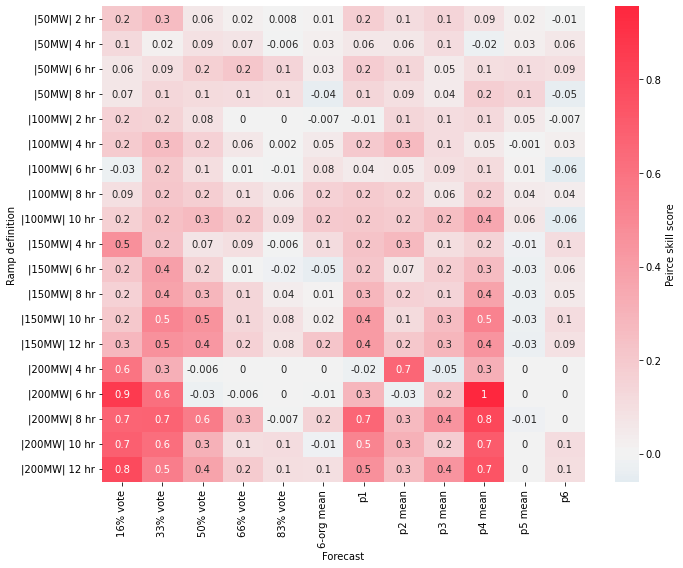

In [33]:
inds = ['peirces_skill_score']
fig_num = 14
cbar_title = 'Peirce skill score'

srdf, rdf_2x2, plot_df = plot_rampmetric_heatmaps(ramp_metrics_df_allm, 'all', inds, fig_num, cbar_title)

symmetric_extreme_dependency_score


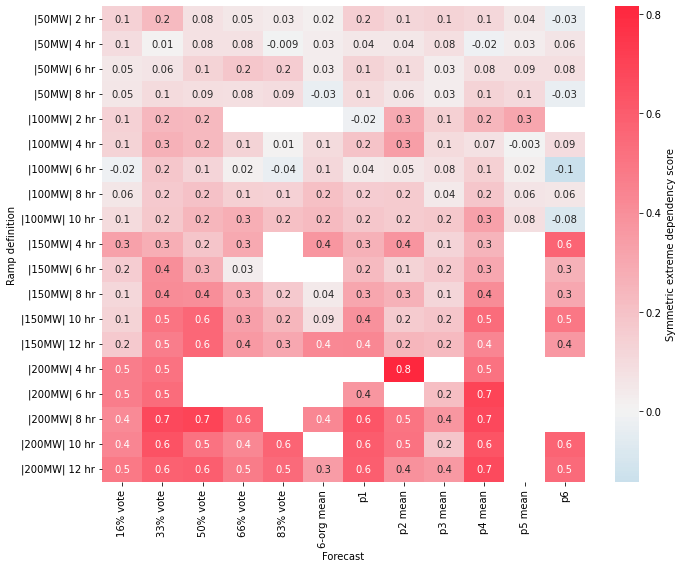

In [34]:
inds = ['symmetric_extreme_dependency_score']
fig_num = 15
cbar_title = 'Symmetric extreme dependency score'

srdf, rdf_2x2, plot_df = plot_rampmetric_heatmaps(ramp_metrics_df_allm, 'all', inds, fig_num, cbar_title)

### fig 16

In [49]:
def get_ramp_dfs(org, lev): 

    case_dir = 'output/baltic-power/'+org+'_ensemble/'

    rampts_df = pd.read_csv(main_dir+case_dir+'ramp_ts_'+org+'.csv', 
                            header=[0, 1, 2, 3, 4, 5], index_col=[0], low_memory=False)
    # df.columns = df.columns.set_levels(
    #       df.columns.levels[1].astype(int), level=1
    # )
    rampts_df.index = pd.to_datetime(rampts_df.index)

    head_num = 4

    file = main_dir+case_dir+'ramp_'+org+'.csv'

    ramp_metrics_df = pd.read_csv(file, header=list(range(0, head_num+1)), index_col=[0])

    rampts_allmems_df = rampts_df[lev].drop(org+'m', axis=1, level=0)

    num_orgs = len(rampts_allmems_df.columns.get_level_values(0).unique())

    # ramp_method = 'r_abs_magnitude_2ms-1_4 hours'

    # vote_thres_dict = {'80%': 0.8, '60%': 0.6, '40%': 0.4, '20%': 0.2, '1%': 0.01}
    # vote_thres_dict = {'20%': 0.2, '15%': 0.15, '10%': 0.1, '5%': 0.05, '2%': 0.02, '1%': 0.01}
    vote_thres_dict = {'100%': 1, '87%': 0.87, 
                       '75%': 0.75, '67%': 0.67, '50%': 0.5, 
                       '37%': 0.37, '25%': 0.25, '12%': 0.12}

    for ramp_method in rampts_allmems_df.xs('comp_ramp', level=4, axis=1).columns.get_level_values(-1).unique(): 

    #     print(ramp_method)

        comp_ramps_df = rampts_allmems_df.xs('comp_ramp', level=4, axis=1).xs(ramp_method, level=-1, axis=1)

        for key, val in vote_thres_dict.items():

    #         print(val)

            simpleramp_df = pd.DataFrame(0, index=rampts_allmems_df.index, 
                                         columns=['base_ramp', 'comp_ramp']).astype(float)

            simpleramp_df['base_ramp'] = rampts_allmems_df.xs('base_ramp', level=4, axis=1).xs(
                ramp_method, level=-1, axis=1).xs(
                org+'-1', level=0, axis=1).values

            for index, row in comp_ramps_df.iterrows():

    #             print(row.values)
    #             print(row.isnull().all())

    #             print(np.nansum(row.values) >= num_orgs*val)

                # vote
                if np.nansum(row.values) >= num_orgs*val:

    #                 print(np.nansum(row.values))

                    simpleramp_df.at[index, 'comp_ramp'] = 1

                if row.isnull().all():

                    simpleramp_df.at[index, 'comp_ramp'] = np.nan

            simpleramp_df.dropna(subset=['base_ramp', 'comp_ramp'], inplace=True)

            process_ramp = eval_tools.get_module_class('ramps', 'process_ramp')(simpleramp_df)
            ramp2b2_df = process_ramp.add_contingency_table()
            ramp_1summary_df = process_ramp.generate_ramp_summary_df()

            ramp2b2_df.columns = pd.MultiIndex.from_product([[lev], [key+'_vote'], [key+'_vote'],
                                                      [rampts_df.columns.get_level_values(3).unique()[0]], 
                                                      [ramp_method], ramp2b2_df.columns]
                                                    )

            rampts_df = rampts_df.join(ramp2b2_df)

            ramp_1summary_df.columns = pd.MultiIndex.from_product([[lev], [key+'_vote'], [key+'_vote'],
                                                      [rampts_df.columns.get_level_values(3).unique()[0]], 
                                                      [ramp_method]]
                                                    )

            ramp_metrics_df = ramp_metrics_df.join(ramp_1summary_df)
            
    return rampts_df, ramp_metrics_df

lev_baltic = '78.25'
rampts_df_p5, ramp_metrics_df_p5 = get_ramp_dfs('p5', lev_baltic) 

r_abs_magnitude_50MW_6 hours: p5


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


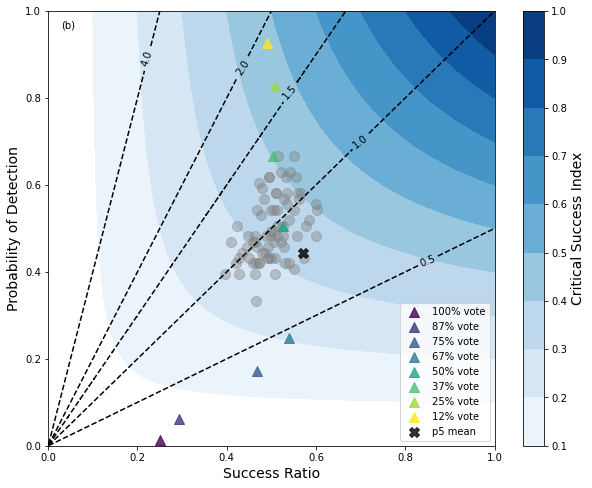

In [51]:
def plot_performance_diag1(ramp_metrics_df, org_name, ramp_definition, ensem_n, skip_n=8):

    fig, ax = plt.subplots(figsize=(10, 8))
    grid_ticks = np.arange(0, 1.001, 0.001)
    sr_g, pod_g = np.meshgrid(grid_ticks, grid_ticks)
    with np.errstate(divide='ignore', invalid='ignore'):
        bias = pod_g / sr_g
        csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)
    csi_contour = plt.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), cmap='Blues')
    b_contour = plt.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors='k', linestyles="dashed")
    plt.clabel(b_contour, fmt='%1.1f', manual=[(0.2, 0.9), (0.4, 0.9), (0.6, 0.75), (0.7, 0.7), (0.95, 0.1)])

    roc_df = ramp_metrics_df.loc(axis=1)[lev, :, :, 'all', ramp_definition,:]

    for ind, ensem_mem in enumerate(roc_df.columns.get_level_values(1)[1:ensem_n+1]):
        
#         print(ensem_mem)

        plt.scatter(roc_df.xs(ensem_mem, axis=1, level=1).loc['forecast_accuracy'].values, 
                    roc_df.xs(ensem_mem, axis=1, level=1).loc['probability_of_detection'].values, 
                    c='grey', s=100, alpha=0.4, label='_nolegend_')
    
    cmap = matplotlib.cm.get_cmap('viridis', skip_n)

    for ind, vote_group in enumerate(roc_df.columns.get_level_values(1)[-skip_n:]):
        
#         print(vote_group)
        group_name = vote_group.replace('_', ' ')

        plt.scatter(roc_df.xs(vote_group, axis=1, level=1).loc['forecast_accuracy'].values, 
                    roc_df.xs(vote_group, axis=1, level=1).loc['probability_of_detection'].values, 
                    c=matplotlib.colors.rgb2hex(cmap(ind)[:3]), s=100, alpha=0.8, marker='^', label=group_name)

    plt.scatter(roc_df.xs(org_name+'m', axis=1, level=1).loc['forecast_accuracy'].values, 
                roc_df.xs(org_name+'m', axis=1, level=1).loc['probability_of_detection'].values, 
                c='k', s=100, marker='X', alpha=0.8, label=org_name+' mean')

    cbar = plt.colorbar(csi_contour)
    cbar.set_label('Critical Success Index', fontsize=14)
    plt.xlabel('Success Ratio', fontsize=14)
    plt.ylabel('Probability of Detection', fontsize=14)
    print(ramp_definition+': '+org_name)
#     plt.title(ramp_definition+': '+org_name, fontsize=14)
    plt.legend(loc='lower right')
    
    ax.text(0.03, 0.96, '(b)', transform=ax.transAxes)

    plt.savefig(f'../publication/plot/Fig16b.pdf', bbox_inches='tight')
    plt.savefig(f'../publication/plot/Fig16b.eps', bbox_inches='tight')
    
    plt.show()
    
plot_performance_diag1(ramp_metrics_df_p5, 'p5', 'r_abs_magnitude_50MW_6 hours', 75)

r_abs_magnitude_50MW_6 hours: all


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


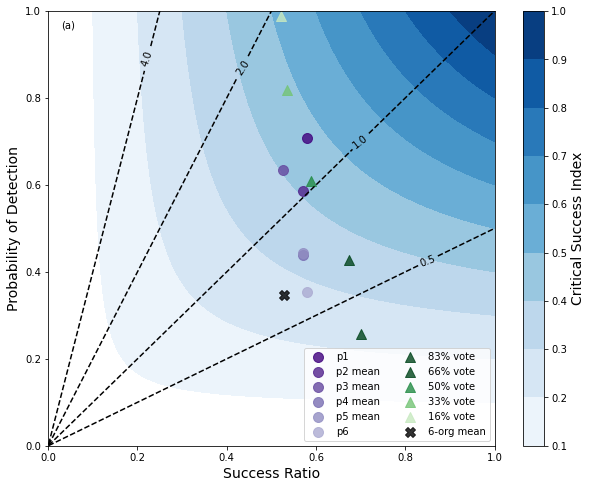

In [67]:
def plot_performance_diag_allm(ramp_metrics_df, org_name, ramp_definition):

    # ramp_metrics_df = ramp_metrics_df_allm
    # org_name = 'all'
    # ramp_definition = 'r_abs_magnitude_50MW_6 hours'

    fig, ax = plt.subplots(figsize=(10, 8))
#     plt.figure(figsize=(10, 8))
    grid_ticks = np.arange(0, 1.001, 0.001)
    sr_g, pod_g = np.meshgrid(grid_ticks, grid_ticks)
    with np.errstate(divide='ignore', invalid='ignore'):
        bias = pod_g / sr_g
        csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)
    csi_contour = plt.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), cmap='Blues')
#     b_contour = plt.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors='k', linestyles="dashed")
#     plt.clabel(b_contour, fmt='%1.1f', manual=[(0.2, 0.9), (0.4, 0.9), (0.6, 0.8), (0.7, 0.7), (0.95, 0.1)])
    b_contour = plt.contour(sr_g, pod_g, bias, [0.5, 1, 2, 4], colors='k', linestyles="dashed")
    plt.clabel(b_contour, fmt='%1.1f', manual=[(0.2, 0.9), (0.4, 0.9), (0.7, 0.7), (0.95, 0.1)])

    roc_df = ramp_metrics_df.loc(axis=1)[lev, :, :, 'all', ramp_definition,:]

    # colors = ['r', 'g', 'b', 'k', 'lime', 'purple']

    cmap = matplotlib.cm.get_cmap('Purples_r', 10)

    for ind, vote_group in enumerate(roc_df.columns.get_level_values(1)[:6]):
        
        if vote_group == 'p1m':
            group_name = 'p1'
        elif vote_group == 'p6m':
            group_name = 'p6'
        else:
            group_name = vote_group.replace('m', ' mean')

        plt.scatter(roc_df.xs(vote_group, axis=1, level=1).loc['forecast_accuracy'].values, 
                    roc_df.xs(vote_group, axis=1, level=1).loc['probability_of_detection'].values, 
                    c=matplotlib.colors.rgb2hex(cmap(ind)[:3]), s=100, alpha=0.8, label=group_name)

    n = 5

    cmap = matplotlib.cm.get_cmap('Greens', n+0)

    for ind, vote_group in enumerate(roc_df.columns.get_level_values(1)[-n:]):

        group_name = vote_group.replace('_', ' ')

        plt.scatter(roc_df.xs(vote_group, axis=1, level=1).loc['forecast_accuracy'].values, 
                    roc_df.xs(vote_group, axis=1, level=1).loc['probability_of_detection'].values, 
                    c=matplotlib.colors.rgb2hex(cmap(n-ind)[:3]), s=100, alpha=0.8, marker='^', label=group_name)

    plt.scatter(roc_df.xs(org_name+'m', axis=1, level=1).loc['forecast_accuracy'].values, 
                roc_df.xs(org_name+'m', axis=1, level=1).loc['probability_of_detection'].values, 
                c='k', s=100, marker='X', alpha=0.8, label='6-org mean')

    cbar = plt.colorbar(csi_contour)
    cbar.set_label('Critical Success Index', fontsize=14)
    plt.xlabel('Success Ratio', fontsize=14)
    plt.ylabel('Probability of Detection', fontsize=14)
    print(ramp_definition+': '+org_name)
#     plt.title(ramp_definition+': '+org_name, fontsize=14)
    plt.legend(loc='lower right', ncol=2)
    
    ax.text(0.03, 0.96, '(a)', transform=ax.transAxes)

    plt.savefig(f'../publication/plot/Fig16a.pdf', bbox_inches='tight')
    plt.savefig(f'../publication/plot/Fig16a.eps', bbox_inches='tight')
    
    plt.show()

plot_performance_diag_allm(ramp_metrics_df_allm, 'all', 'r_abs_magnitude_50MW_6 hours')

## new figs

### fig 3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


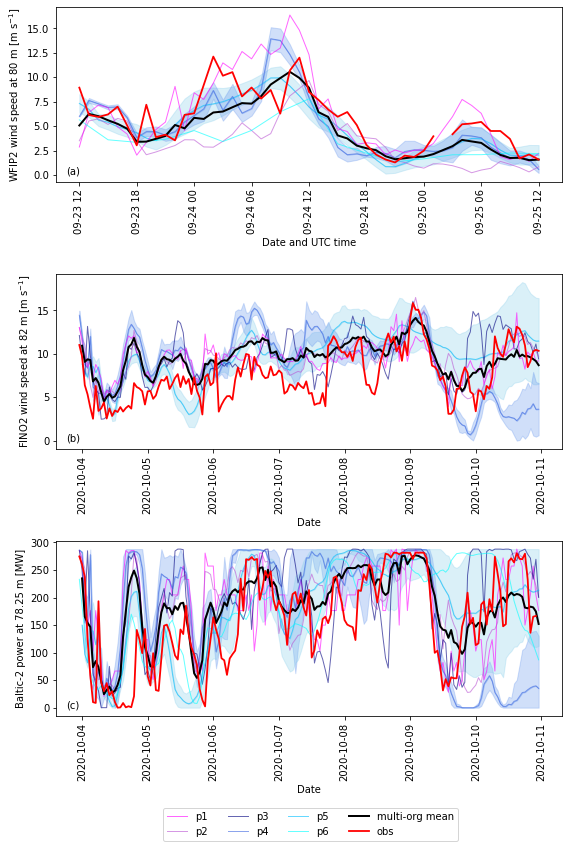

In [28]:
al_pha = 0.6

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))

mem_lw = 1

lev_wfip2 = '80'
case = 'wfip2'

ax1.plot(df_p5_sum_wfip2.index, df_p5_sum_wfip2[lev_wfip2]['mean'], c=p5_clr, label='p5', alpha=al_pha, linewidth=mem_lw)
ax1.fill_between(df_p5_sum_wfip2.index, df_p5_sum_wfip2[lev_wfip2]['mean'], 
                df_p5_sum_wfip2[lev_wfip2]['mean']+df_p5_sum_wfip2[lev_wfip2]['std'], color=p5_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

s5_down_wfip2 = df_p5_sum_wfip2[lev_wfip2]['mean']-df_p5_sum_wfip2[lev_wfip2]['std']
s5_down_wfip2.loc[s5_down_wfip2 < 0] = 0
ax1.fill_between(df_p5_sum_wfip2.index, df_p5_sum_wfip2[lev_wfip2]['mean'], s5_down_wfip2, color=p5_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

ax1.plot(df_p4_sum_wfip2.index, df_p4_sum_wfip2[lev_wfip2]['mean'], c=p4_clr, label='p4', alpha=al_pha, linewidth=mem_lw)
ax1.fill_between(df_p4_sum_wfip2.index, df_p4_sum_wfip2[lev_wfip2]['mean'], 
                df_p4_sum_wfip2[lev_wfip2]['mean']+df_p4_sum_wfip2[lev_wfip2]['std'], color=p4_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

s4_down_wfip2 = df_p4_sum_wfip2[lev_wfip2]['mean']-df_p4_sum_wfip2[lev_wfip2]['std']
s4_down_wfip2.loc[s4_down_wfip2 < 0] = 0
ax1.fill_between(df_p4_sum_wfip2.index, df_p4_sum_wfip2[lev_wfip2]['mean'], s4_down_wfip2, color=p4_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

ax1.plot(df_p2_sum_wfip2.index, df_p2_sum_wfip2[lev_wfip2]['mean'], c=p2_clr, label='p2', alpha=al_pha, linewidth=mem_lw)

ax1.plot(df_p1_wfip2.index, df_p1_wfip2[lev_wfip2]['p1']['p1_ws'], label='p1', c=p1_clr, alpha=al_pha, linewidth=mem_lw)

ax1.plot(df_p6_wfip2.index, df_p6_wfip2[lev_wfip2]['p6-1']['p6-1_ws'], label='p6', c=p6_clr, alpha=al_pha, linewidth=mem_lw)

ax1.plot(org_mean_df_wfip2.index, org_mean_df_wfip2.drop(columns=case).mean(axis=1), label='avg', c='k', linewidth=2)

ax1.plot(df_p1_wfip2.index, df_p1_wfip2[lev_wfip2]['p1'][case+'_ws'], label='fino tower', c='red', linewidth=1.8)

var_txt = 'WFIP2 wind speed at '+lev_wfip2+' m'

# ax1.set_xticklabels(rotation=90)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
# ax1.set_xlabel('Date and UTC time')
ax1.set_ylabel(var_txt+r' [m s$^{-1}$]')
# plt.title(case+' case: '+var_txt)
# plt.legend(bbox_to_anchor=(1.03, 1.02), loc='upper left')

ax1.set_xlabel('Date and UTC time')

ax1.text(0.02, 0.04, '(a)', transform=ax1.transAxes)

lev_fino2 = '82'
case = 'fino'

ax2.plot(df_p5_sum_fino2.index, df_p5_sum_fino2[lev_fino2]['mean'], c=p5_clr, label='p5', alpha=al_pha, linewidth=mem_lw)
ax2.fill_between(df_p5_sum_fino2.index, df_p5_sum_fino2[lev_fino2]['mean'], 
                df_p5_sum_fino2[lev_fino2]['mean']+df_p5_sum_fino2[lev_fino2]['std'], color=p5_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

s5_down_fino2 = df_p5_sum_fino2[lev_fino2]['mean']-df_p5_sum_fino2[lev_fino2]['std']
s5_down_fino2.loc[s5_down_fino2< 0] = 0
ax2.fill_between(df_p5_sum_fino2.index, df_p5_sum_fino2[lev_fino2]['mean'], s5_down_fino2, color=p5_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

ax2.plot(df_p4_sum_fino2.index, df_p4_sum_fino2[lev_fino2]['mean'], c=p4_clr, label='p4', alpha=al_pha, linewidth=mem_lw)
ax2.fill_between(df_p4_sum_fino2.index, df_p4_sum_fino2[lev_fino2]['mean'], 
                df_p4_sum_fino2[lev_fino2]['mean']+df_p4_sum_fino2[lev_fino2]['std'], color=p4_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

s4_down_fino2 = df_p4_sum_fino2[lev_fino2]['mean']-df_p4_sum_fino2[lev_fino2]['std']
s4_down_fino2.loc[s4_down_fino2 < 0] = 0
ax2.fill_between(df_p4_sum_fino2.index, df_p4_sum_fino2[lev_fino2]['mean'], s4_down_fino2, color=p4_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

ax2.plot(df_p3_sum_fino2.index, df_p3_sum_fino2[lev_fino2]['mean'], c=p3_clr, label='p3', alpha=al_pha, linewidth=mem_lw)

ax2.plot(df_p2_sum_fino2.index, df_p2_sum_fino2[lev_fino2]['mean'], c=p2_clr, label='p2', alpha=al_pha, linewidth=mem_lw)

ax2.plot(df_p1_fino2.index, df_p1_fino2[lev_fino2]['p1']['p1_ws'], label='p1', c=p1_clr, alpha=al_pha, linewidth=mem_lw)

ax2.plot(org_base_df_fino2.index, org_base_df_fino2.drop(columns=case).mean(axis=1), label='avg', c='k', linewidth=2)

ax2.plot(df_p1_fino2.index, df_p1_fino2[lev_fino2]['p1'][case+'_ws'], label='fino tower', c='red', linewidth=1.8)

var_txt = 'FINO2 wind speed at '+lev_fino2+' m'

ax2.set_xlabel('Date')

# ax1.set_xticklabels(rotation=90)
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
# ax1.set_xlabel('Date and UTC time')
ax2.set_ylabel(var_txt+r' [m s$^{-1}$]')

ax2.text(0.02, 0.04, '(b)', transform=ax2.transAxes)

lev_baltic = '78.25'

ax3.plot(df_p1_baltic.index, df_p1_baltic[lev_baltic]['p1']['p1_power'], label='p1', c=p1_clr, alpha=al_pha, linewidth=mem_lw)

ax3.plot(df_p2_sum_baltic.index, df_p2_sum_baltic[lev_baltic]['mean'], c=p2_clr, label='p2', alpha=al_pha, linewidth=mem_lw)

ax3.plot(df_p3_sum_baltic.index, df_p3_sum_baltic[lev_baltic]['mean'], c=p3_clr, label='p3', alpha=al_pha, linewidth=mem_lw)

ax3.plot(df_p4_sum_baltic.index, df_p4_sum_baltic[lev_baltic]['mean'], c=p4_clr, label='p4', alpha=al_pha, linewidth=mem_lw)

s4_up_baltic = df_p4_sum_baltic[lev_baltic]['mean']+df_p4_sum_baltic[lev_baltic]['std']
s4_up_baltic.loc[s4_up_baltic > 288] = 288

s4_down_baltic = df_p4_sum[lev_baltic]['mean']-df_p4_sum[lev_baltic]['std']
s4_down_baltic.loc[s4_down_baltic < 0] = 0

ax3.fill_between(df_p4_sum_baltic.index, df_p4_sum_baltic[lev_baltic]['mean'], s4_up_baltic, color=p4_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)
ax3.fill_between(df_p4_sum_baltic.index, df_p4_sum_baltic[lev_baltic]['mean'], s4_down_baltic, color=p4_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

ax3.plot(df_p5_sum_baltic.index, df_p5_sum_baltic[lev_baltic]['mean'], c=p5_clr, label='p5', alpha=al_pha, linewidth=mem_lw)

s5_up_baltic = df_p5_sum_baltic[lev_baltic]['mean']+df_p5_sum_baltic[lev_baltic]['std']
s5_up_baltic.loc[s5_up_baltic > 288] = 288

s5_down_baltic = df_p5_sum_baltic[lev_baltic]['mean']-df_p5_sum_baltic[lev_baltic]['std']
s5_down_baltic.loc[s5_down_baltic < 0] = 0

ax3.fill_between(df_p5_sum_baltic.index, df_p5_sum_baltic[lev_baltic]['mean'], s5_up_baltic, color=p5_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)
ax3.fill_between(df_p5_sum_baltic.index, df_p5_sum_baltic[lev_baltic]['mean'], s5_down_baltic, color=p5_sclr, 
                label='_nolegend_', alpha=al_pha-0.3)

ax3.plot(df_p6_baltic.index, df_p6_baltic[lev_baltic]['p6-1']['p6-1_power'], label='p6', c=p6_clr, alpha=al_pha, linewidth=mem_lw)

ax3.plot(org_mean_alllev_df_baltic.index, org_mean_alllev_df_baltic[lev_baltic], label='multi-org mean', c='k', linewidth=2)

ax3.plot(df_p1_baltic.index, df_p1_baltic[lev_baltic]['p1']['baltic_power'], label='obs', c='red', linewidth=1.8)

var_txt = 'Baltic-2 power at '+lev_baltic+' m'

# plt.xticks(rotation=90)
# plt.ylim((0, 288))

ax3.text(0.02, 0.04, '(c)', transform=ax3.transAxes)

# ax1.set_xticklabels(rotation=90)
for tick in ax3.get_xticklabels():
    tick.set_rotation(90)

ax3.set_xlabel('Date')
ax3.set_ylabel(var_txt+r' [MW]')
# plt.title(case+' case: '+var_txt)
# plt.legend(bbox_to_anchor=(1.03, 1.02), loc='upper left')

plt.legend(bbox_to_anchor=(0.805, -0.5), ncol=4)

plt.tight_layout()

plt.savefig('../publication/plot/Fig3.pdf')
plt.savefig('../publication/plot/Fig3.eps')

plt.show()

### fig 7

p4m 4336.326309808886
p5m 3776.2827082827494
p5-13 3637.538281303584
p5-29 3322.2860408329047
p5-37 3607.9943653395494
p5-49 3514.07698705686
p5-61 3626.740893270075
p1 4118.446401958245
p2 4647.966097656431
p3 6053.020144656736
p4 4336.326309808886
p5 3776.2827082827494
p6 3689.5488110707397
all 2352.5822293893516


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


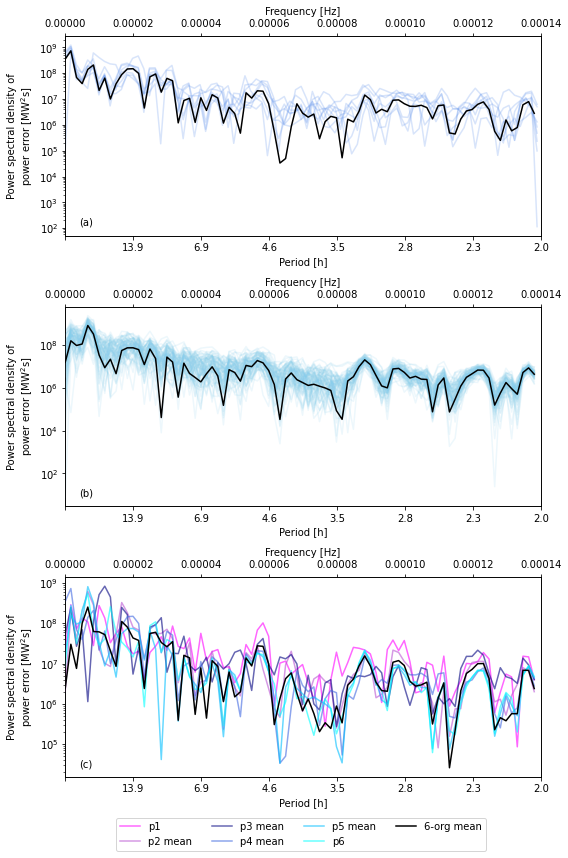

In [87]:
df_p4 = read_ts_df('baltic-power', 'p4', sub='60min')
df_p4.dropna(inplace=True)
df_p4 = df_p4['78.25']

means_ts = read_ts_df('baltic-power/allmeans', 'allmeans', sub='60min')
means_ts.dropna(inplace=True)
means_ts = means_ts['78.25']

def plot_sq_p_error_spectrum_p4(p, p_color, thres, alpha=0.3):
    
    p_diff = (df_p4[p][p+'_power'] - df_p4['p4-1']['baltic_power'])

    freq, power = welch(p_diff.values, fs=1/3600, nperseg=len(p_diff))
        
    plt.plot(freq, power, label='_nolegend_', c=p_color, alpha=alpha)
    
    integral = scipy.integrate.cumtrapz(power, freq, initial=0)[-1]
    
    if integral < thres:
        print(p, integral)
    
    return freq, power


fig, (axa, axb, axc) = plt.subplots(3, 1, figsize=(8, 12))

ax2 = axa.twiny()

p_diff_m = means_ts['p4m']['p4m_power'] - means_ts['p4m']['baltic_power']

freq_m, power_m = welch(p_diff_m.values, fs=1/3600, nperseg=len(p_diff_m))

print('p4m', scipy.integrate.cumtrapz(power_m, freq_m, initial=0)[-1])

p4m_intg = scipy.integrate.cumtrapz(power_m, freq_m, initial=0)[-1]

for mem in df_p4.columns.get_level_values(0).unique():

    freq, power = plot_sq_p_error_spectrum_p4(mem, p4_sclr, p4m_intg, alpha=0.25)

plt.plot(freq_m, power_m, label='p4 mean', c='k', alpha=1)

# ax.set_xscale('log')
axa.set_yscale('log')
ax2.set_xlim(0, 1/(119*60))

with np.errstate(divide='ignore'):
    bottom_xticks = list(np.round(1/ax2.get_xticks()/3600, 1))
bottom_xticks = [str(i) for i in bottom_xticks]
bottom_xticks[0] = ''

ticks_loc = np.linspace(0, 1, 8)
axa.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
axa.set_xticklabels(bottom_xticks[:-1])
ax2.set_xlabel('Frequency [Hz]')
axa.set_xlabel('Period [h]')
axa.set_ylabel(r'Power spectral density of''\n''power error [MW${^2}$s]')
# plt.title('Squared power error power spectrum of p4 ensemble members and mean')

# plt.legend()

axa.text(0.03, 0.05, '(a)', transform=axa.transAxes)

df_p5 = read_ts_df('baltic-power', 'p5', sub='60min')
df_p5.dropna(inplace=True)
df_p5 = df_p5['78.25']

def plot_sq_p_error_spectrum_p5(p, p_color, thres, alpha=0.3):
    
    p_diff = (df_p5[p][p+'_power'] - df_p5['p5-1']['baltic_power'])
    
    # hourly data for fs
    # nperseg is analysis period divided by dt
    freq, power = welch(p_diff.values, fs=1/3600, nperseg=len(p_diff))
        
    plt.plot(freq, power, label='_nolegend_', c=p_color, alpha=alpha)
    
    integral = scipy.integrate.cumtrapz(power, freq, initial=0)[-1]
    
    if integral < thres:
        print(p, integral)
    
    return freq, power

ax2 = axb.twiny()

p_diff_m = means_ts['p5m']['p5m_power'] - means_ts['p5m']['baltic_power']

freq_m, power_m = welch(p_diff_m.values, fs=1/3600, nperseg=len(p_diff_m))

print('p5m', scipy.integrate.cumtrapz(power_m, freq_m, initial=0)[-1])

p5m_intg = scipy.integrate.cumtrapz(power_m, freq_m, initial=0)[-1]

for mem in df_p5.columns.get_level_values(0).unique():

    freq, power = plot_sq_p_error_spectrum_p5(mem, p5_sclr, p5m_intg, alpha=0.15)

plt.plot(freq_m, power_m, label='p5 mean', c='k', alpha=1)

# ax.set_xscale('log')
axb.set_yscale('log')
ax2.set_xlim(0, 1/(119*60))

with np.errstate(divide='ignore'):
    bottom_xticks = list(np.round(1/ax2.get_xticks()/3600, 1))
bottom_xticks = [str(i) for i in bottom_xticks]
bottom_xticks[0] = ''

ticks_loc = np.linspace(0, 1, 8)
axb.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
axb.set_xticklabels(bottom_xticks[:-1])

ax2.set_xlabel('Frequency [Hz]')
axb.set_xlabel('Period [h]')
axb.set_ylabel(r'Power spectral density of''\n''power error [MW${^2}$s]')
# plt.title('Squared power error power spectrum of p5 ensemble members and mean')

# plt.legend()

axb.text(0.03, 0.05, '(b)', transform=axb.transAxes)

def plot_sq_p_error_spectrum(p, p_color, alpha=0.6, label=None):
    
    p_diff = (means_ts[p+'m'][p+'m_power'] - means_ts['p1m']['baltic_power'])
    
    # hourly data for fs
    # nperseg is analysis period divided by dt
    # use a smaller nperseg could give better results 
    # according to https://stackoverflow.com/questions/65725179/usage-of-signal-welch
    # result should be power spectral density
    freq, power = welch(p_diff, fs=1/3600, nperseg=len(p_diff))
    
    # integrate area should = np.sum(p_diff**2)
    # integration function is not exact
    # need to multiply by len(p_diff) to get the right magnitude?
    print(p, scipy.integrate.cumtrapz(power, freq, initial=0)[-1])
    
    if label is None:
        plt.plot(freq, power, label=p, c=p_color, alpha=alpha)
    else:
        plt.plot(freq, power, label=label, c=p_color, alpha=alpha)
    
    return freq, power

ax2 = axc.twiny()

freq, power = plot_sq_p_error_spectrum('p1', p1_clr)
freq, power = plot_sq_p_error_spectrum('p2', p2_clr, label='p2 mean')
freq, power = plot_sq_p_error_spectrum('p3', p3_clr, label='p3 mean')
freq, power = plot_sq_p_error_spectrum('p4', p4_clr, label='p4 mean')
freq, power = plot_sq_p_error_spectrum('p5', p5_clr, label='p5 mean')
freq, power = plot_sq_p_error_spectrum('p6', p6_clr)
freq, power = plot_sq_p_error_spectrum('all', 'k', alpha=1, label='6-org mean')

# ax.set_xscale('log')
axc.set_yscale('log')
ax2.set_xlim(0, 1/(119*60))

with np.errstate(divide='ignore'):
    bottom_xticks = list(np.round(1/ax2.get_xticks()/3600, 1))
bottom_xticks = [str(i) for i in bottom_xticks]
bottom_xticks[0] = ''

ticks_loc = np.linspace(0, 1, 8)
axc.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
axc.set_xticklabels(bottom_xticks[:-1])

ax2.set_xlabel('Frequency [Hz]')
axc.set_xlabel('Period [h]')
axc.set_ylabel(r'Power spectral density of''\n''power error [MW${^2}$s]')
# plt.title('Squared power error power spectrum of 5 organizations and mean')

plt.legend(bbox_to_anchor=(0.895, -0.18), ncol=4)

axc.text(0.03, 0.05, '(c)', transform=axc.transAxes)

plt.tight_layout()

plt.savefig('../publication/plot/Fig7.pdf')
plt.savefig('../publication/plot/Fig7.eps')

plt.show()
# plt.show()